# Predicting daily TSLA stock direction with machine learning <br> (and other strategies)

In [1]:
# import libraries
import credentials
import pandas as pd
import numpy as np
import random

# visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px

# sklearn
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier

# fintech
import talib
import yfinance as yf
import nasdaqdatalink
import mplfinance as mpf

# deep learning
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam, RMSprop

%matplotlib inline
%config InlineBackend.figure_format = "retina"

import warnings
warnings.filterwarnings('ignore')

# seaborn style and color palette
sns.set_style('darkgrid')
sns.set_palette('colorblind')

C:\Users\brian\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\brian\anaconda3\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
C:\Users\brian\anaconda3\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


## Obtaining & preparing data

### Obtaining data
- Tesla stock will be used for this project

In [2]:
day_df = yf.download("TSLA",               # obtaining data for Tesla stock  
                     start='2022-04-19',   # 1 year of data  
                     end='2023-04-20',     
                     interval='1d')        # daily statistics

[*********************100%***********************]  1 of 1 completed


### Preparing TSLA stock data
- Add daily log returns

In [3]:
def add_returns(df):
    '''
    Adds column with natural log of percentage change between intervals
    '''
    
    df['return'] = np.log(df['Adj Close'] / df['Adj Close'].shift(1))                  
    
    # Division by shifted values creates useless NA values
    df.dropna(inplace=True) 

In [4]:
add_returns(day_df)
day_df.head()

Open        High         Low       Close   Adj Close  \
Date                                                                     
2022-04-20  343.333344  344.666656  325.083344  325.733337  325.733337   
2022-04-21  358.243347  364.073334  332.140015  336.260010  336.260010   
2022-04-22  338.303345  344.950012  331.333344  335.016663  335.016663   
2022-04-25  326.323334  336.206665  325.100006  332.673340  332.673340   
2022-04-26  331.809998  333.333344  291.666656  292.140015  292.140015   

               Volume    return  
Date                             
2022-04-20   70711200 -0.050825  
2022-04-21  105416400  0.031806  
2022-04-22   69696600 -0.003704  
2022-04-25   68341200 -0.007019  
2022-04-26  136133700 -0.129928

- Add lags of returns

In [5]:
def add_lags(df):
    
    '''Add price lags based on log returns of "Adj Close";
       Specify number of lags in first line'''
    
    lags = 10    
    cols = []
    
    df = df[['Adj Close']]
    df.rename(columns={'Adj Close': 'price'}, inplace=True)
    df['return'] = np.log(df['price'] / df['price'].shift(1))
        
    for lag in range(1, lags + 1):
        col = f'lag_{lag}'
        df[col] = df['return'].shift(lag)
        cols.append(col)
     
    df.dropna(inplace=True)
    
    return(df)

In [6]:
lag_day_df = add_lags(day_df)
lag_day_df.head()

price    return     lag_1     lag_2     lag_3     lag_4  \
Date                                                                       
2022-05-05  291.093323 -0.086960  0.046596  0.006964  0.036290 -0.007722   
2022-05-06  288.549988 -0.008776 -0.086960  0.046596  0.006964  0.036290   
2022-05-09  262.369995 -0.095113 -0.008776 -0.086960  0.046596  0.006964   
2022-05-10  266.679993  0.016294 -0.095113 -0.008776 -0.086960  0.046596   
2022-05-11  244.666672 -0.086153  0.016294 -0.095113 -0.008776 -0.086960   

               lag_5     lag_6     lag_7     lag_8     lag_9    lag_10  
Date                                                                    
2022-05-05 -0.004548  0.005791 -0.129928 -0.007019 -0.003704  0.031806  
2022-05-06 -0.007722 -0.004548  0.005791 -0.129928 -0.007019 -0.003704  
2022-05-09  0.036290 -0.007722 -0.004548  0.005791 -0.129928 -0.007019  
2022-05-10  0.006964  0.036290 -0.007722 -0.004548  0.005791 -0.129928  
2022-05-11  0.046596  0.006964  0.036290 -0.007722 -0.004548  0.005791

## Exploratory data analysis (EDA) and visualization

- Various market indicator data was explored including US Treasury data, Financial industry regulatory authority (FINRA) data, and Federal Reserve Bank data, but a comparison with TSLA stock data did not reveal useful insight
- Calculated market indicator data did show value, specifically the moving average convergence divergence (MACD)
    - The MACD defines two moving averages and their relative position to one another can be indicative of the stock movement

In [7]:
df = day_df.copy()

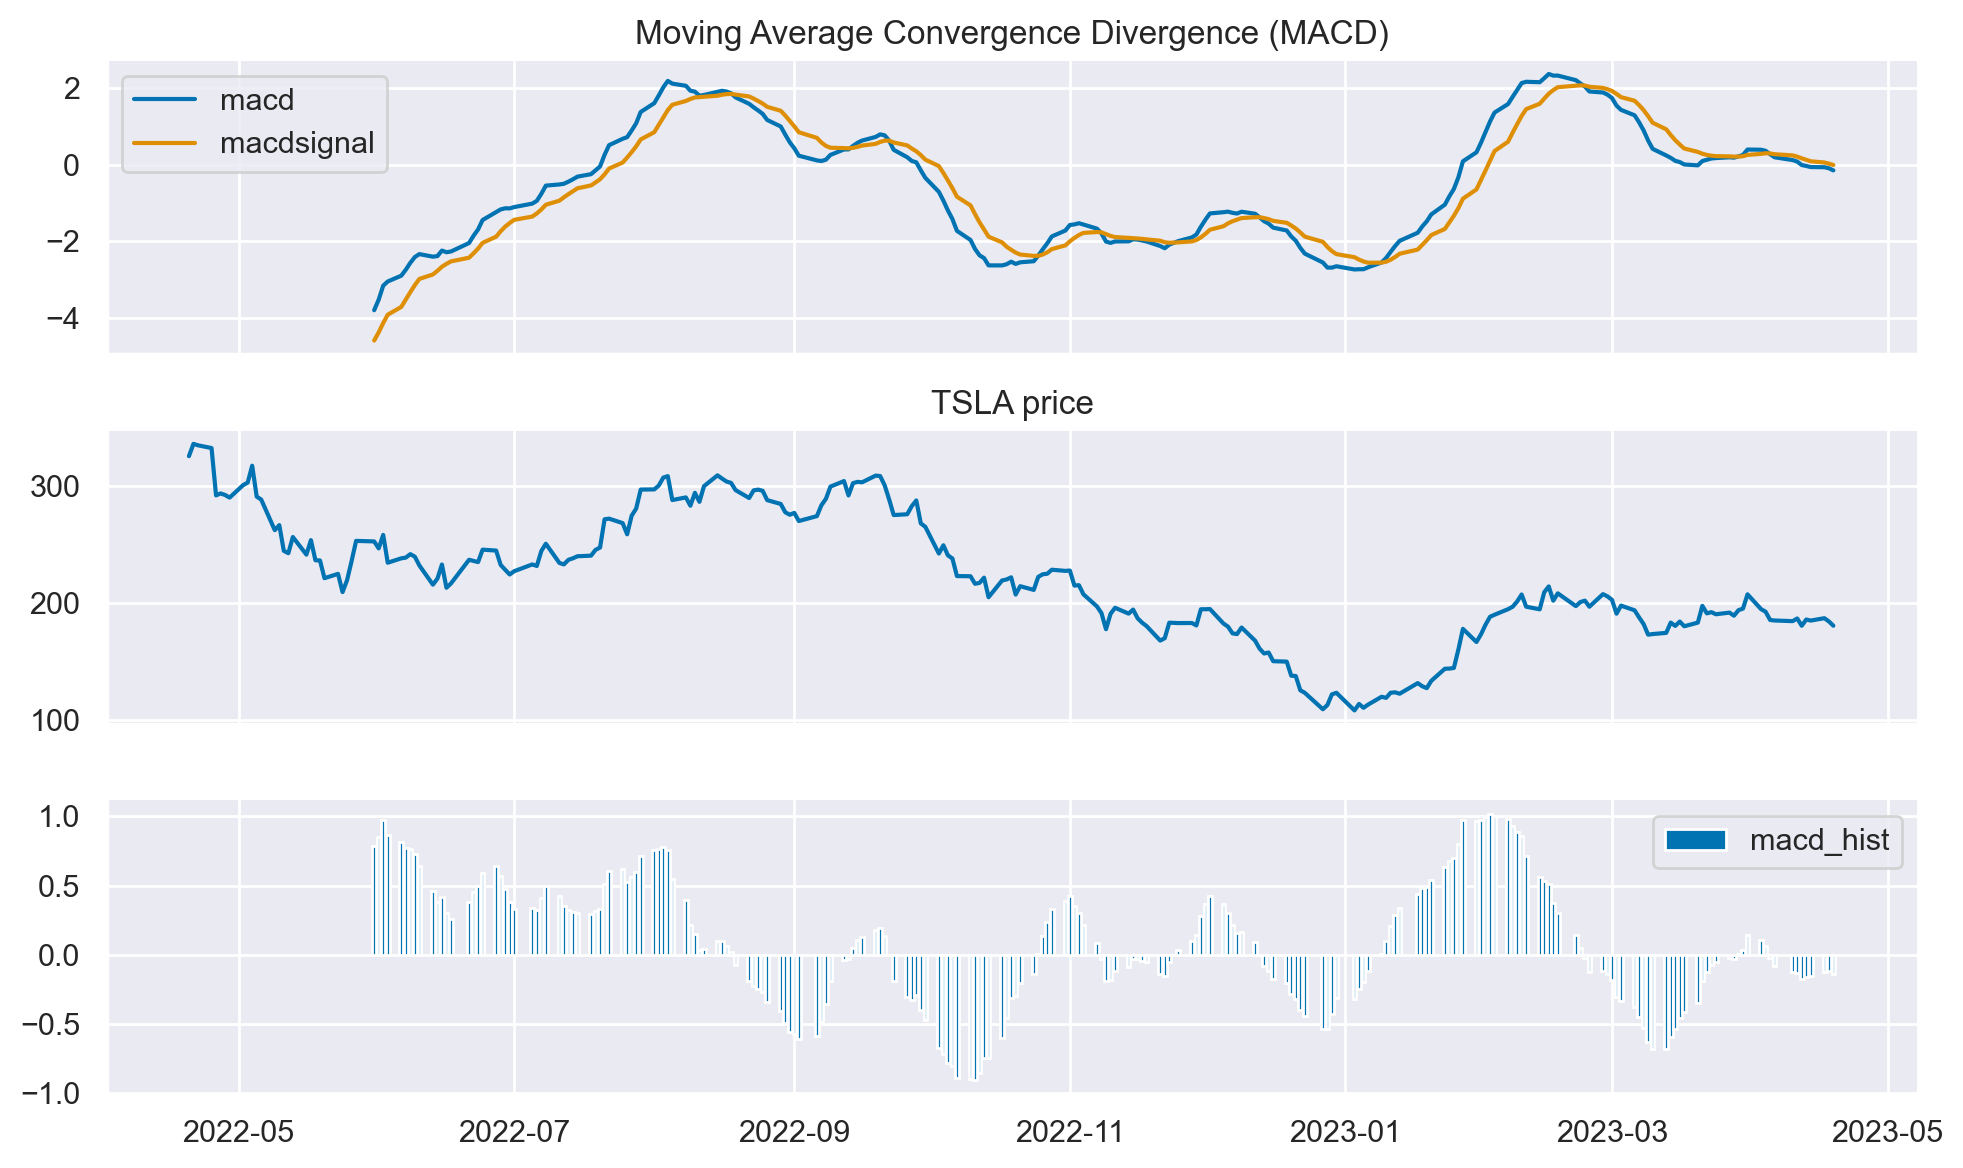

In [8]:
df["macd"], df["macdsignal"], df["macdhist"] = talib.MACD(df["Adj Close"], fastperiod=19, slowperiod=21, signalperiod=9)

with sns.plotting_context("notebook"):
    fig, ax = plt.subplots(3, 1, sharex=True)

    (df[["macd", "macdsignal"]].plot(ax=ax[0], figsize=(10, 6), title="Moving Average Convergence Divergence (MACD)"))
    df['Adj Close'].plot(ax=ax[1], title='TSLA price')
    ax[2].bar(df.index, df["macdhist"].values, label="macd_hist")
    ax[2].legend()
    

    sns.despine()
    plt.tight_layout()

- The top plot includes a 19-day & 21-day moving average of the TSLA stock (plot #2) and the bottom plot is indicative of the position & distance between the moving averages
- A strategy based on these parameters is analyzed further at a later stage

## Modeling Strategies
- Indicator strategies (MACD, etc.)
- Linear Regression
- Logistic Regression
- Deep Learning

Analysis of strategies focus on the period of 1/1/23 - 4/20/23. This corresponds with the start date of test data in later stages.

### Indicator Strategies

#### Moving average convergence diverence (MACD) strategy
- The MACD strategy defines 2 simple moving averages (SMA) and uses relative positioning to determine market position
- 'Buy' when SMA1 exceeds SMA2, and 'sell' when SMA2 exceeds SMA1

In [9]:
df = day_df[['Adj Close', 'return']].copy()

# strategy begins on this date to align with ML test data dates
df = df.loc['2023-01-01':,:]

# set rolling averages
df['SMA1'] = df['Adj Close'].rolling(7).mean()
df['SMA2'] = df['Adj Close'].rolling(9).mean()

# create buy/sell signal
df['position'] = np.where(df['SMA1'] > df['SMA2'], 1, -1)

# nulls created by rolling average calculations
df.dropna(inplace=True)

In [10]:
df.head()

Adj Close    return        SMA1        SMA2  position
Date                                                              
2023-01-13  122.400002 -0.009432  118.742856  116.993332         1
2023-01-17  131.490005  0.071636  121.764285  119.592222         1
2023-01-18  128.779999 -0.020825  124.010000  121.274444         1
2023-01-19  127.169998 -0.012581  125.067143  123.144444         1
2023-01-20  133.419998  0.047977  127.148572  125.406666         1

<AxesSubplot:title={'center':'TSLA | 7 & 9 days SMA'}, xlabel='Date'>

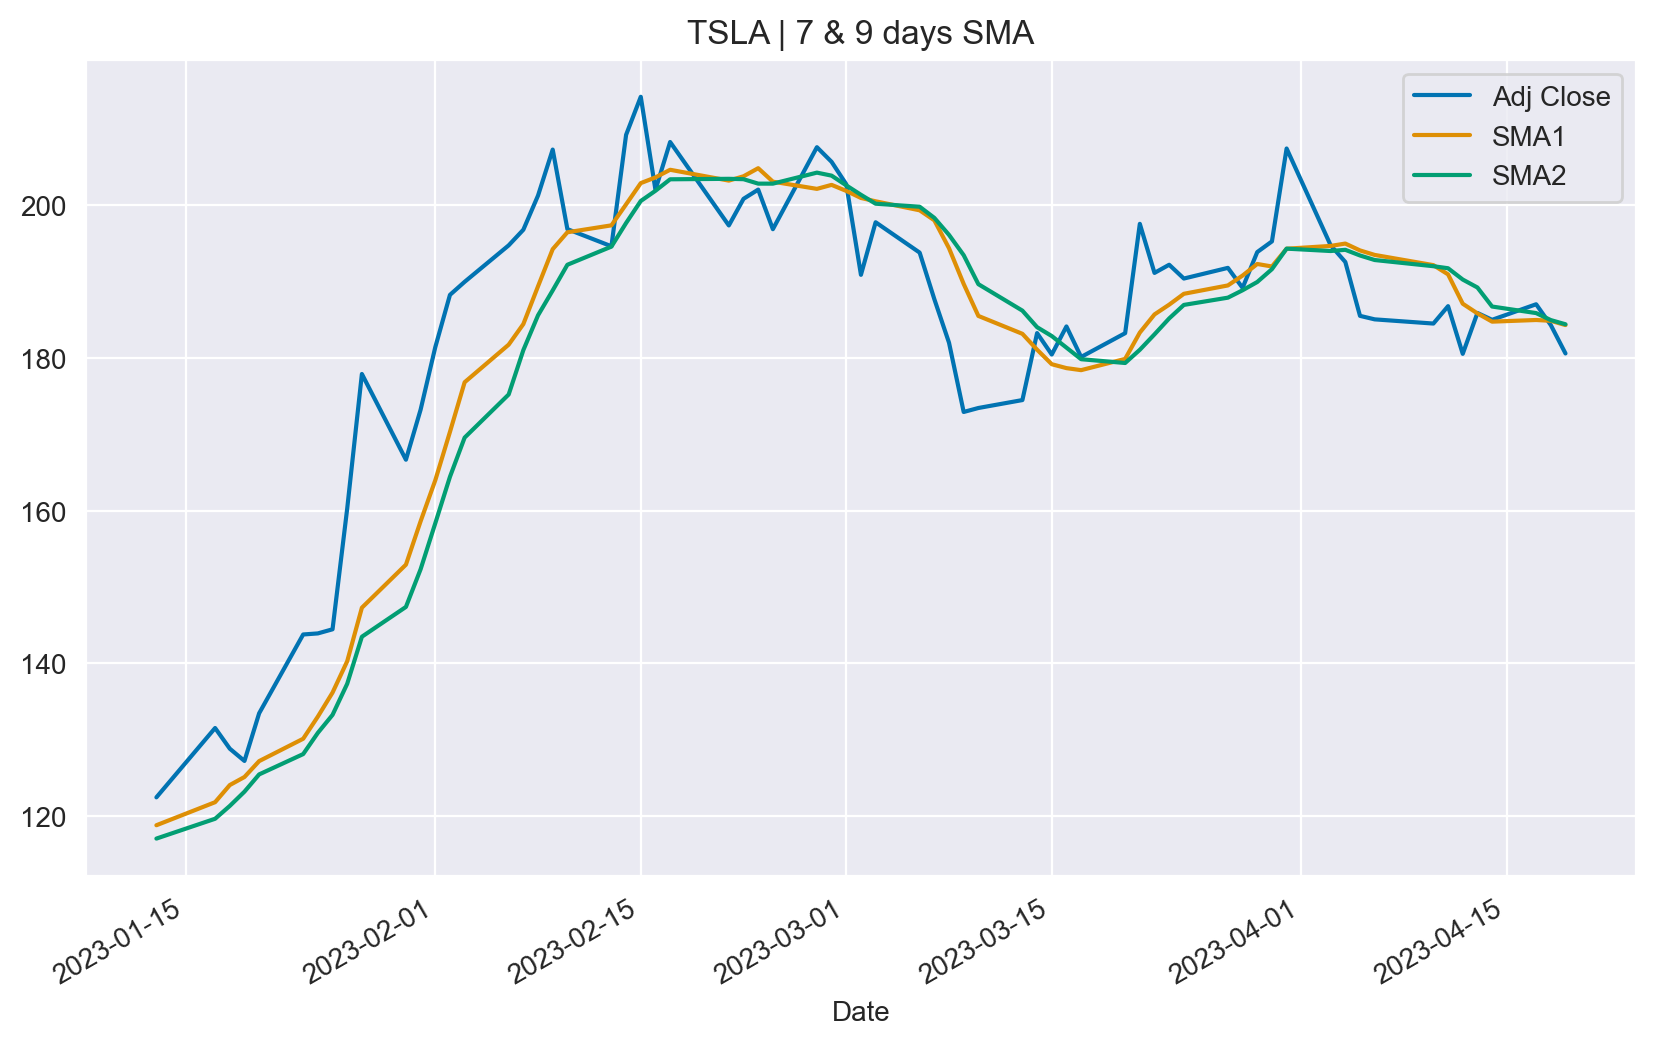

In [11]:
df[['Adj Close', 'SMA1', 'SMA2']].plot(title='TSLA | 7 & 9 days SMA', figsize=(10, 6))

- Buy periods occur when the orange line is above the green line, while sell periods occur when the green line is above the orange line

In [12]:
# identify correct movement direction
df['actual'] = np.where(df['return'] > 0, 1, -1)
df['actual'].value_counts()

 1    36
-1    30
Name: actual, dtype: int64

In [13]:
success_rate = np.sign(df['return'] * df['position'].shift(1)).value_counts()
success_rate

 1.0    40
-1.0    25
dtype: int64

- With the given parameters, there were 40 'buy' days and 25 'sell' days
- The actual distribution was 36 'buy' and 30 'sell'

In [14]:
# assign position for accuracy score
pos = df[['position']].shift(1)
# drop null created by shift
pos = pos.iloc[1:]
# drop row 1 to match 'pos' index
act = df[['actual']].iloc[1:]

accuracy_score(act, pos)

0.6153846153846154

In [15]:
# extra check
success_rate = np.sign(df['return'] * df['position'].shift(1)).value_counts()
success_pct = (success_rate.values[0] / sum(success_rate))
print(f'Correct on {success_pct:.0%} of predictions')

Correct on 62% of predictions


In [16]:
# converting short positions (-1) to closed/sold (0)
df.position[df.position < 0] = 0

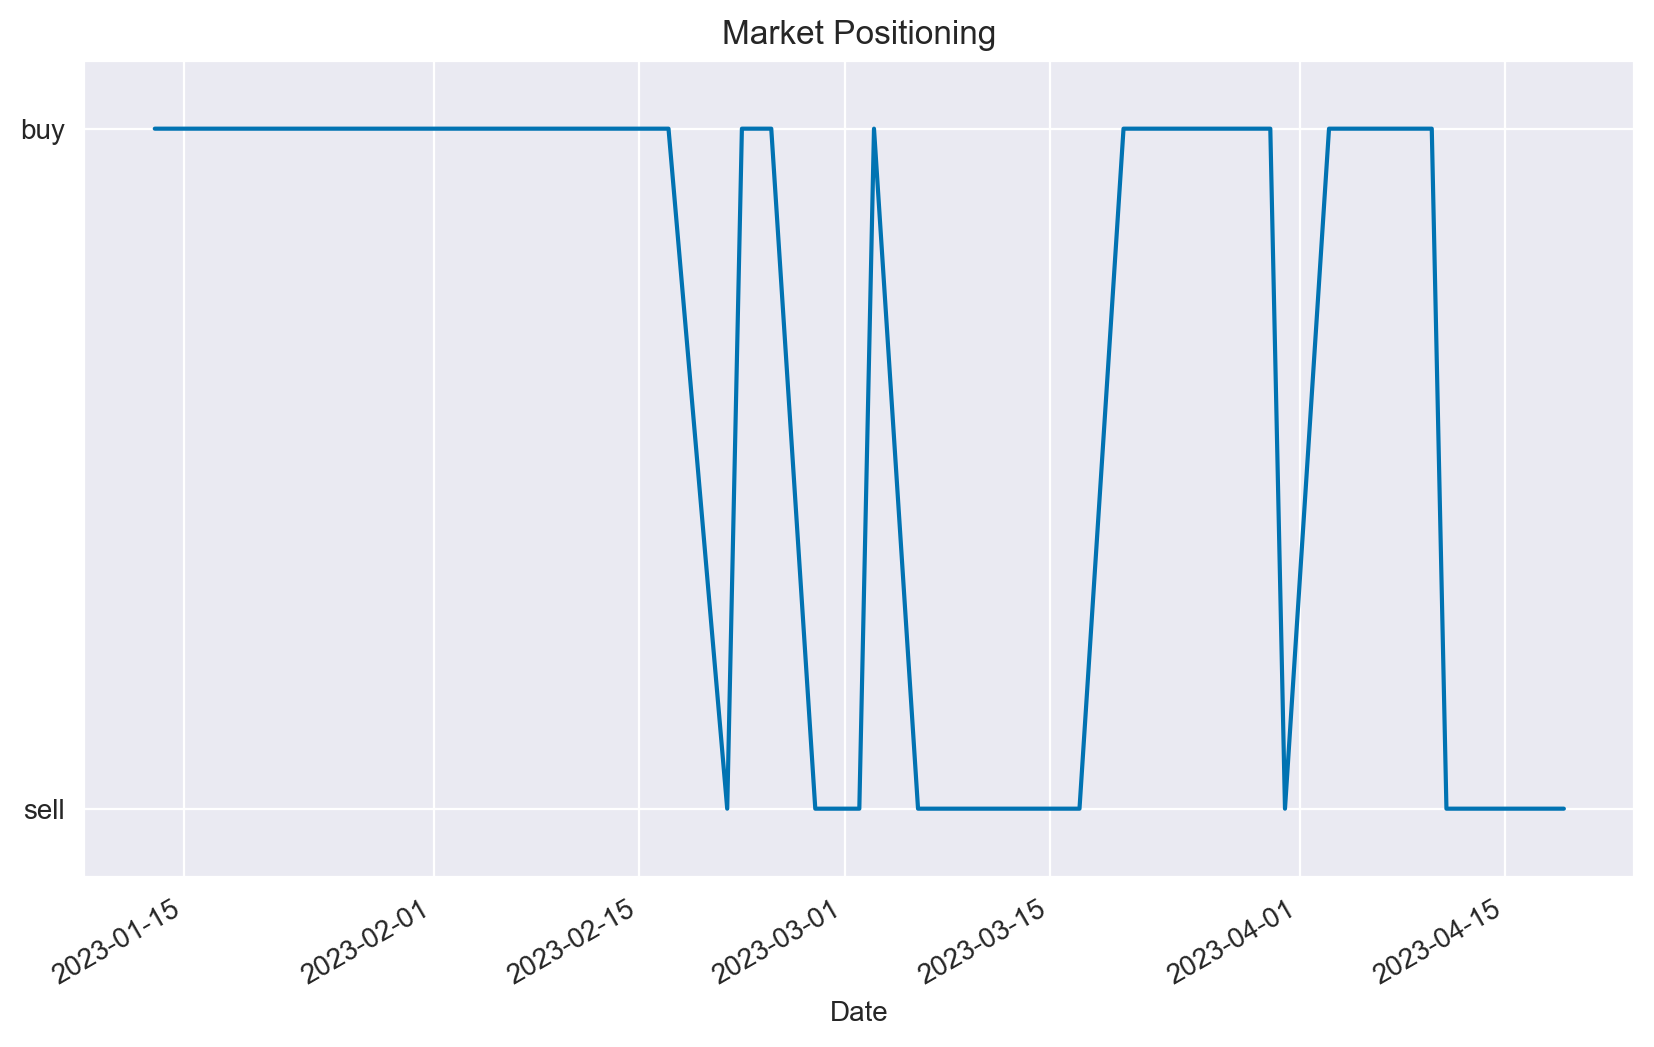

In [17]:
buy_sell_labels = {0.0: 'sell', 1.0: 'buy'}
ax = df['position'].plot(ylim=[-0.1, 1.1], title='Market Positioning', figsize=(10, 6))
_ = plt.yticks(list(buy_sell_labels.keys()), list(buy_sell_labels.values()))

- January was the best time to be invested in TSLA this year

In [18]:
# strategy return uses '.shift(1)' 
# since the decision to invest (i.e. position) is determined by the prior day closing price

df['strategy'] = df['position'].shift(1) * df['return']  
df.dropna(inplace=True)

Text(0.5, 1.0, 'Stock Price vs. Strategy')

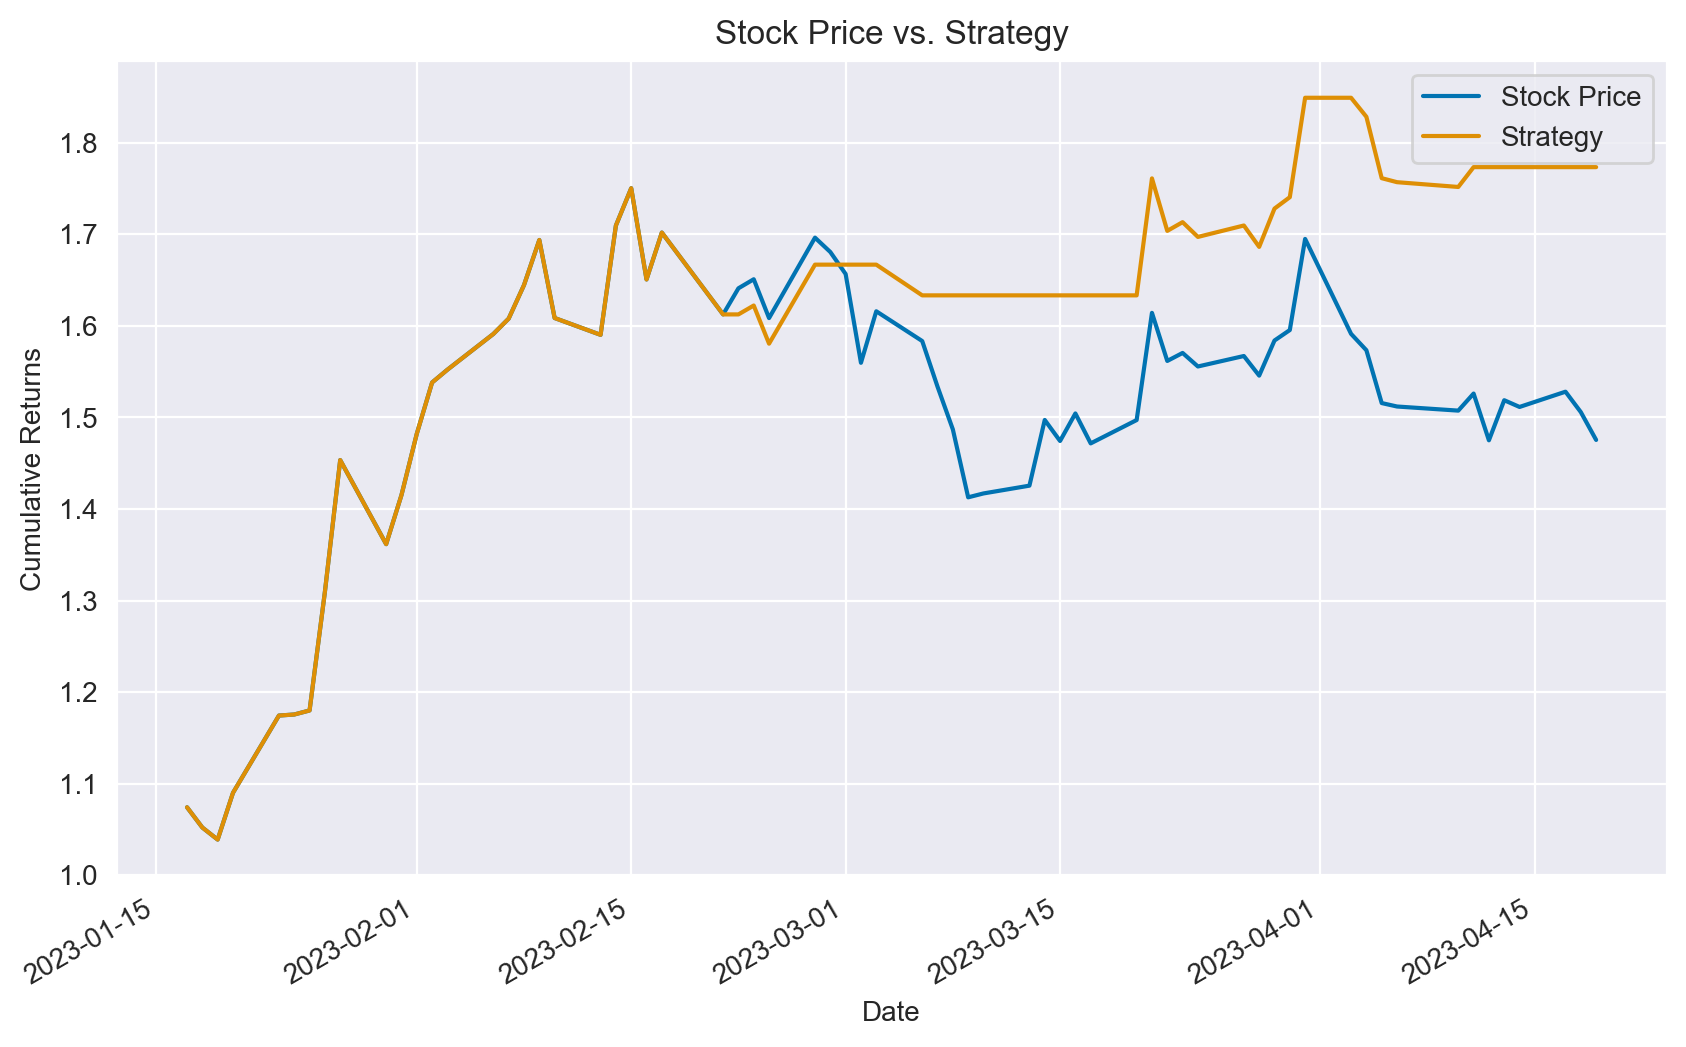

In [19]:
# Plot the data and set the legend label for 'return' to 'stock price'
ax = df[['return', 'strategy']].cumsum().apply(np.exp).plot(figsize=(10, 6))
ax.legend(['Stock Price', 'Strategy'])

# Set the axis labels and title
ax.set_xlabel('Date')
ax.set_ylabel('Cumulative Returns')
ax.set_title('Stock Price vs. Strategy')

In [20]:
df[['return', 'strategy']].cumsum().apply(np.exp).tail(1)

return  strategy
Date                          
2023-04-19  1.475408  1.773332

In [21]:
(1.773332-1.475408)

0.29792399999999986

- The strategy outperformed the stock

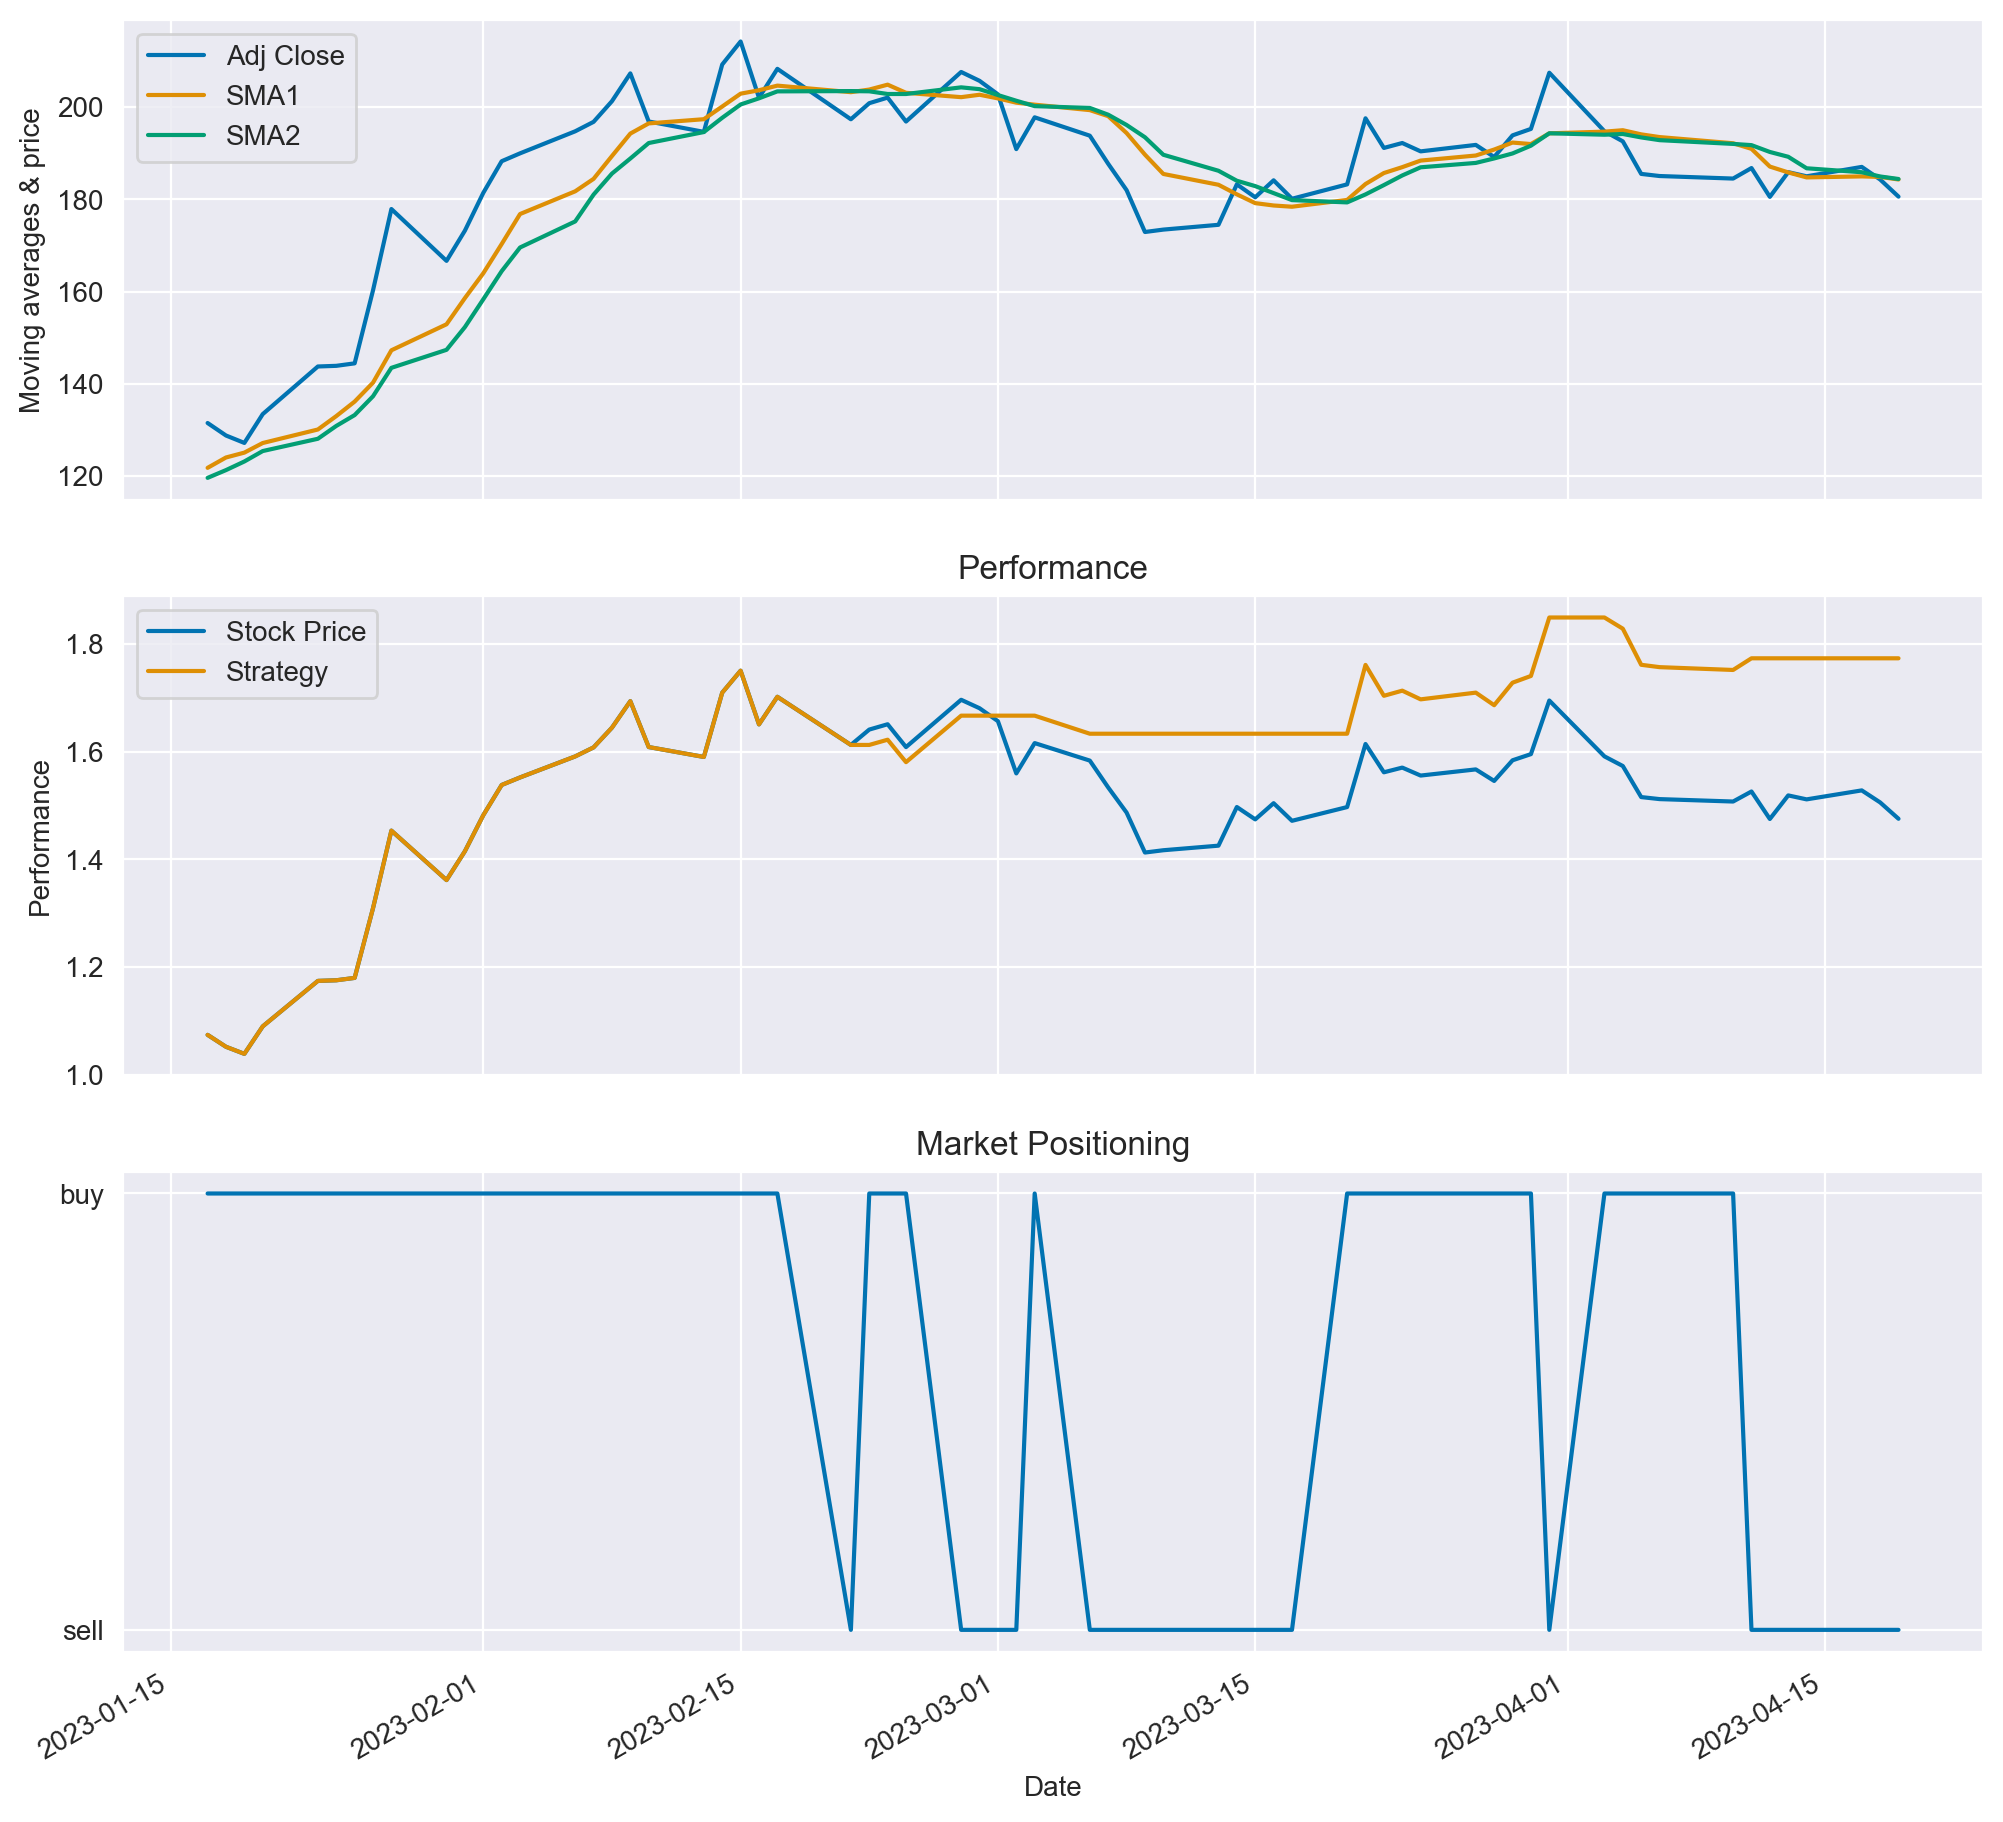

In [22]:
fig, ax = plt.subplots(3, 1, figsize=(12, 12), sharex=True)

df[['Adj Close', 'SMA1', 'SMA2']].plot(ax=ax[0])
ax[0].set(ylabel="Moving averages & price", xlabel="Date")
ax[0].legend()

df[['return', 'strategy']].cumsum().apply(np.exp).plot(ax=ax[1])
ax[1].legend(['Stock Price', 'Strategy'])
ax[1].set(title='Performance', ylabel='Performance')

buy_sell_labels = {0.0: 'sell', 1.0: 'buy'}
df['position'].plot(ax=ax[2], title='Market Positioning')
_ = plt.yticks(list(buy_sell_labels.keys()), list(buy_sell_labels.values()))


#### Momentum strategy

In [23]:
df = day_df[['Adj Close', 'return']].copy()

# strategy begins on this date
df = df.loc['2023-01-01':,:]

# 8-day rolling average
df['avg_mom'] = df['Adj Close'].rolling(8).mean()

# buy/sell signal
df['position'] = np.sign(df['return'].rolling(8).mean())
df.dropna(inplace=True)

In [24]:
# identify correct movement direction
df['actual'] = np.where(df['return'] > 0, 1, -1)
df['actual'].value_counts()

 1    37
-1    30
Name: actual, dtype: int64

In [25]:
success_rate = np.sign(df['return'] * df['position'].shift(1)).value_counts()
success_rate

 1.0    38
-1.0    28
dtype: int64

- With the given parameters, there were 38 'buy' days and 28 'sell' days
- The actual distribution was 37 'buy' and 30 'sell'

In [26]:
# assign position for accuracy score
pos = df[['position']].shift(1)
# drop null created by shift
pos = pos.iloc[1:]
# drop row 1 to match 'pos' index
act = df[['actual']].iloc[1:]

accuracy_score(act, pos)

0.5757575757575758

In [27]:
# extra check
success_rate = np.sign(df['return'] * df['position'].shift(1)).value_counts()
success_pct = (success_rate.values[0] / sum(success_rate))
print(f'Correct on {success_pct:.0%} of predictions')

Correct on 58% of predictions


In [28]:
# convert short positions (-1) to closed/sold (0)
df['position'][df['position'] < 0] = 0

# strategy return uses '.shift(1)' 
df['strategy'] = df['position'].shift(1) * df['return']
df.dropna(inplace=True)

In [29]:
df.head(2)

Adj Close    return     avg_mom  position  actual  strategy
Date                                                                    
2023-01-13  122.400002 -0.009432  118.104999       1.0      -1 -0.009432
2023-01-17  131.490005  0.071636  120.336249       1.0       1  0.071636

<AxesSubplot:title={'center':'TSLA | 8-day SMA'}, xlabel='Date'>

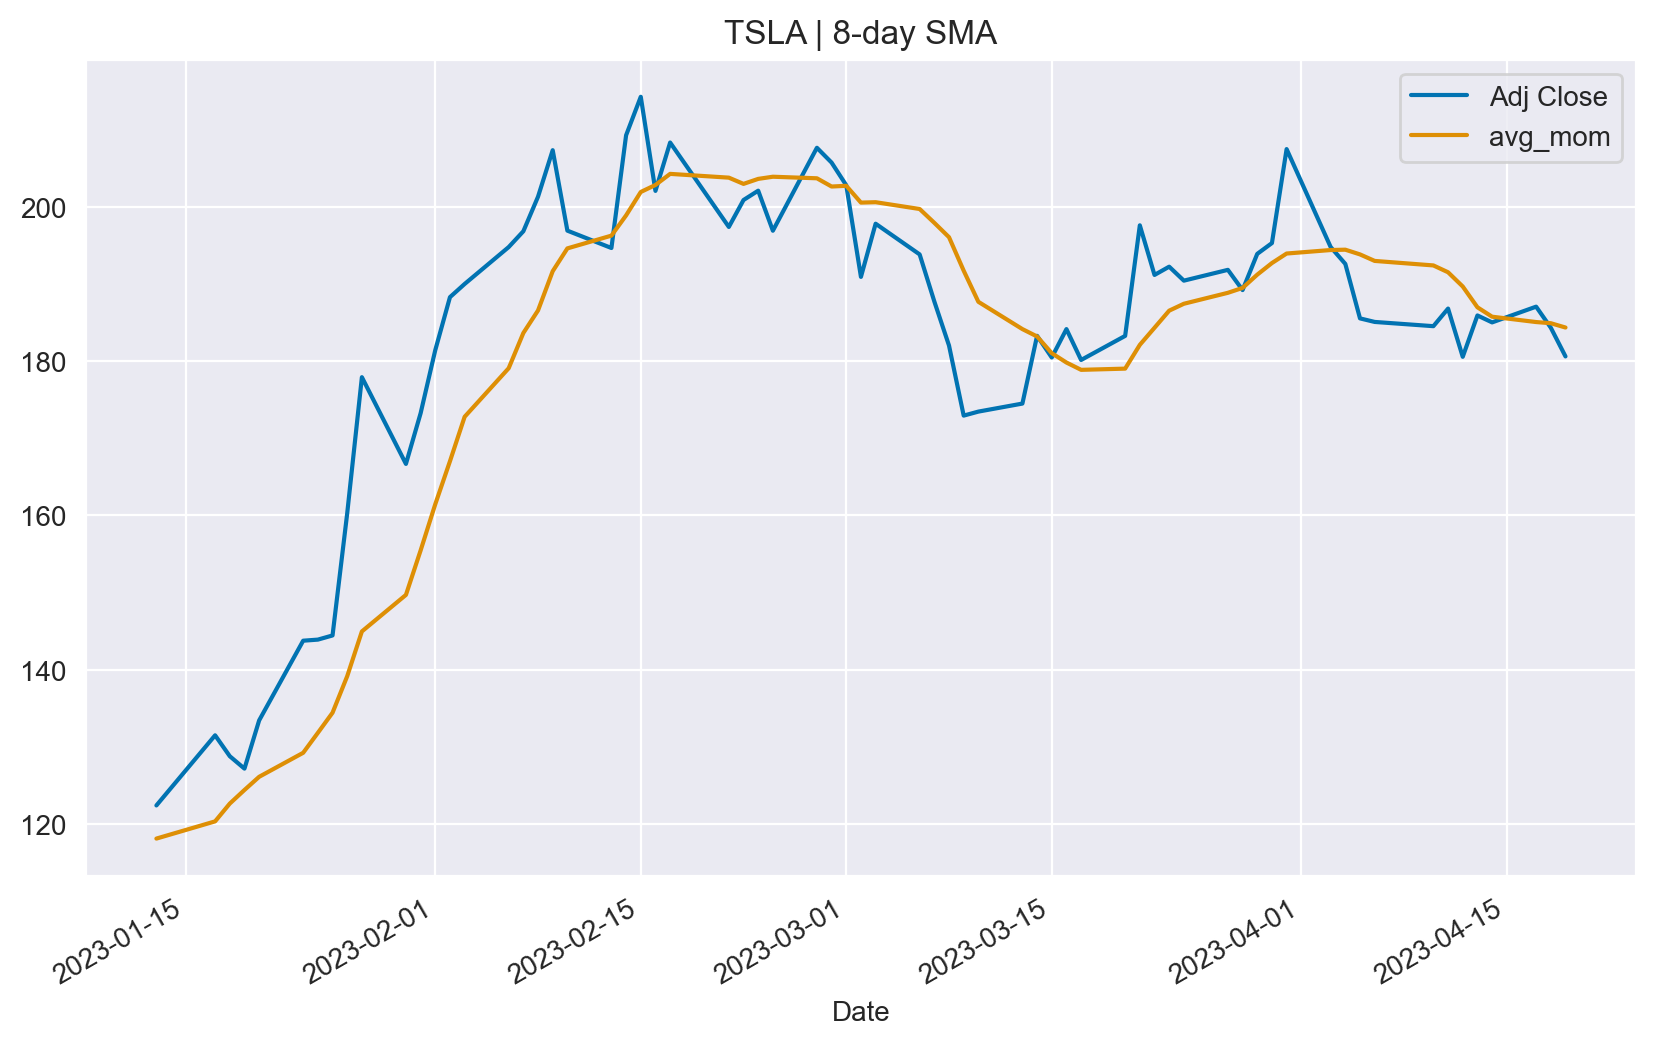

In [30]:
df[['Adj Close', 'avg_mom']].plot(title='TSLA | 8-day SMA', figsize=(10, 6))

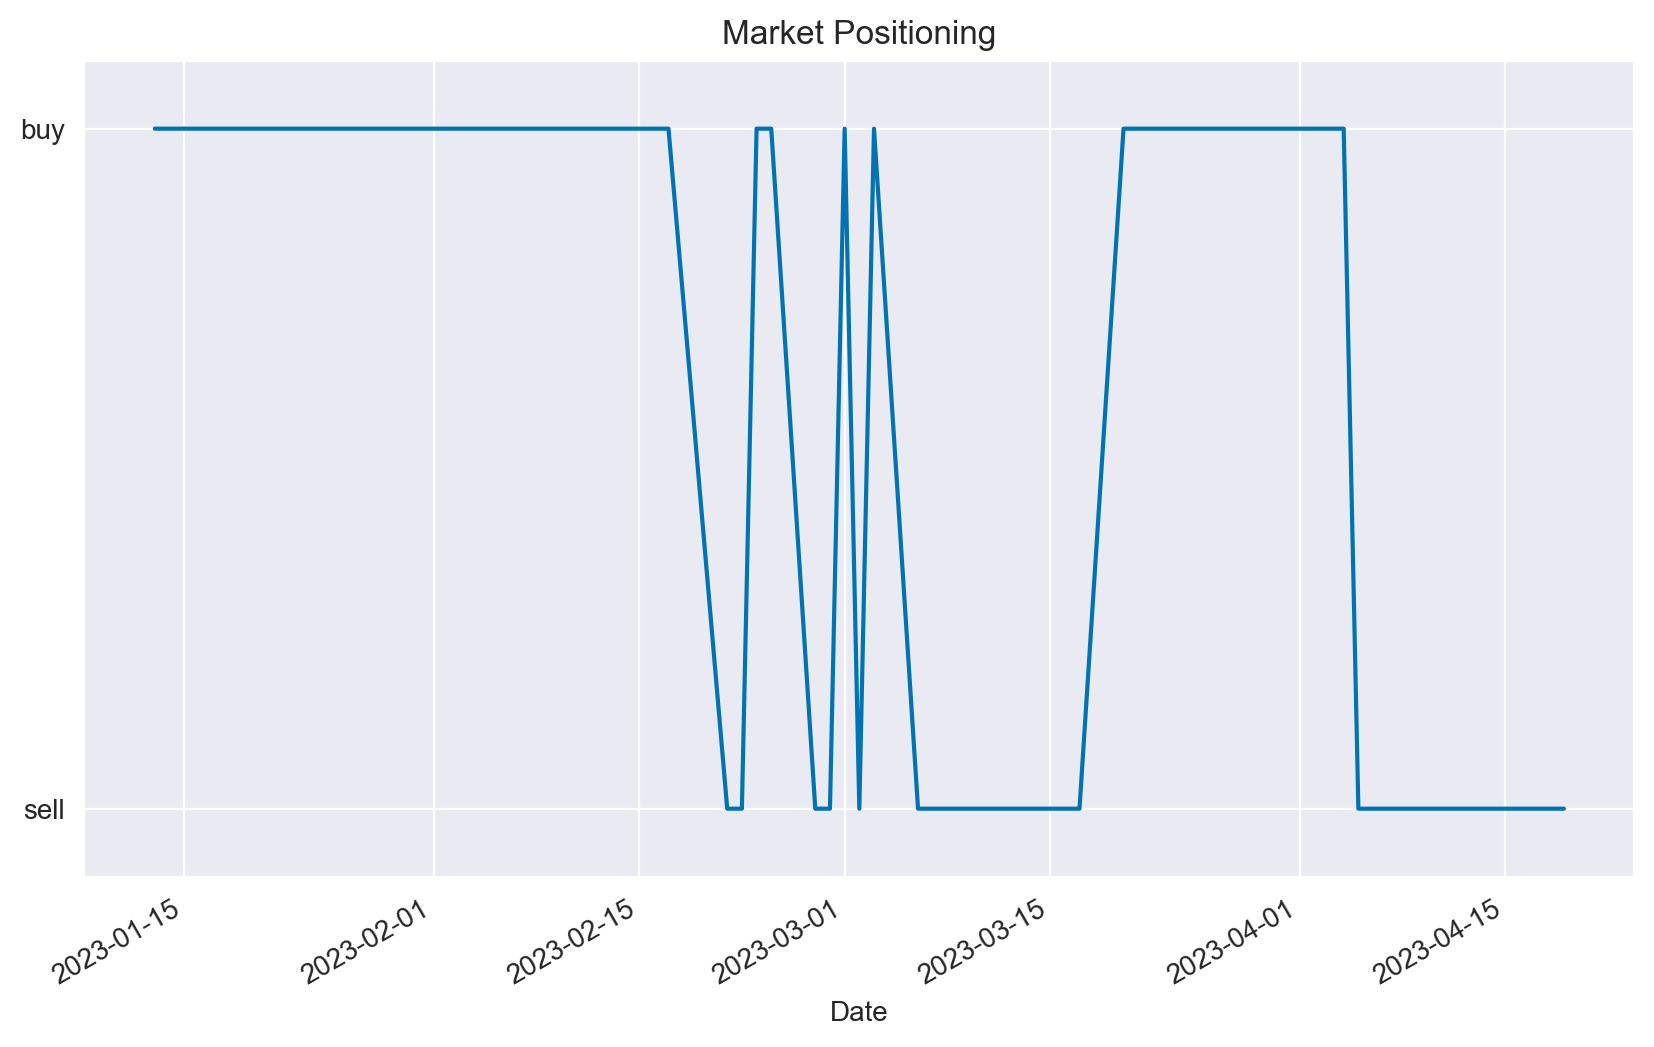

In [31]:
buy_sell_labels = {0.0: 'sell', 1.0: 'buy'}
ax = df['position'].plot(ylim=[-0.1, 1.1], title='Market Positioning', figsize=(10, 6))
_ = plt.yticks(list(buy_sell_labels.keys()), list(buy_sell_labels.values()))

Text(0.5, 1.0, 'Stock Price vs. Strategy')

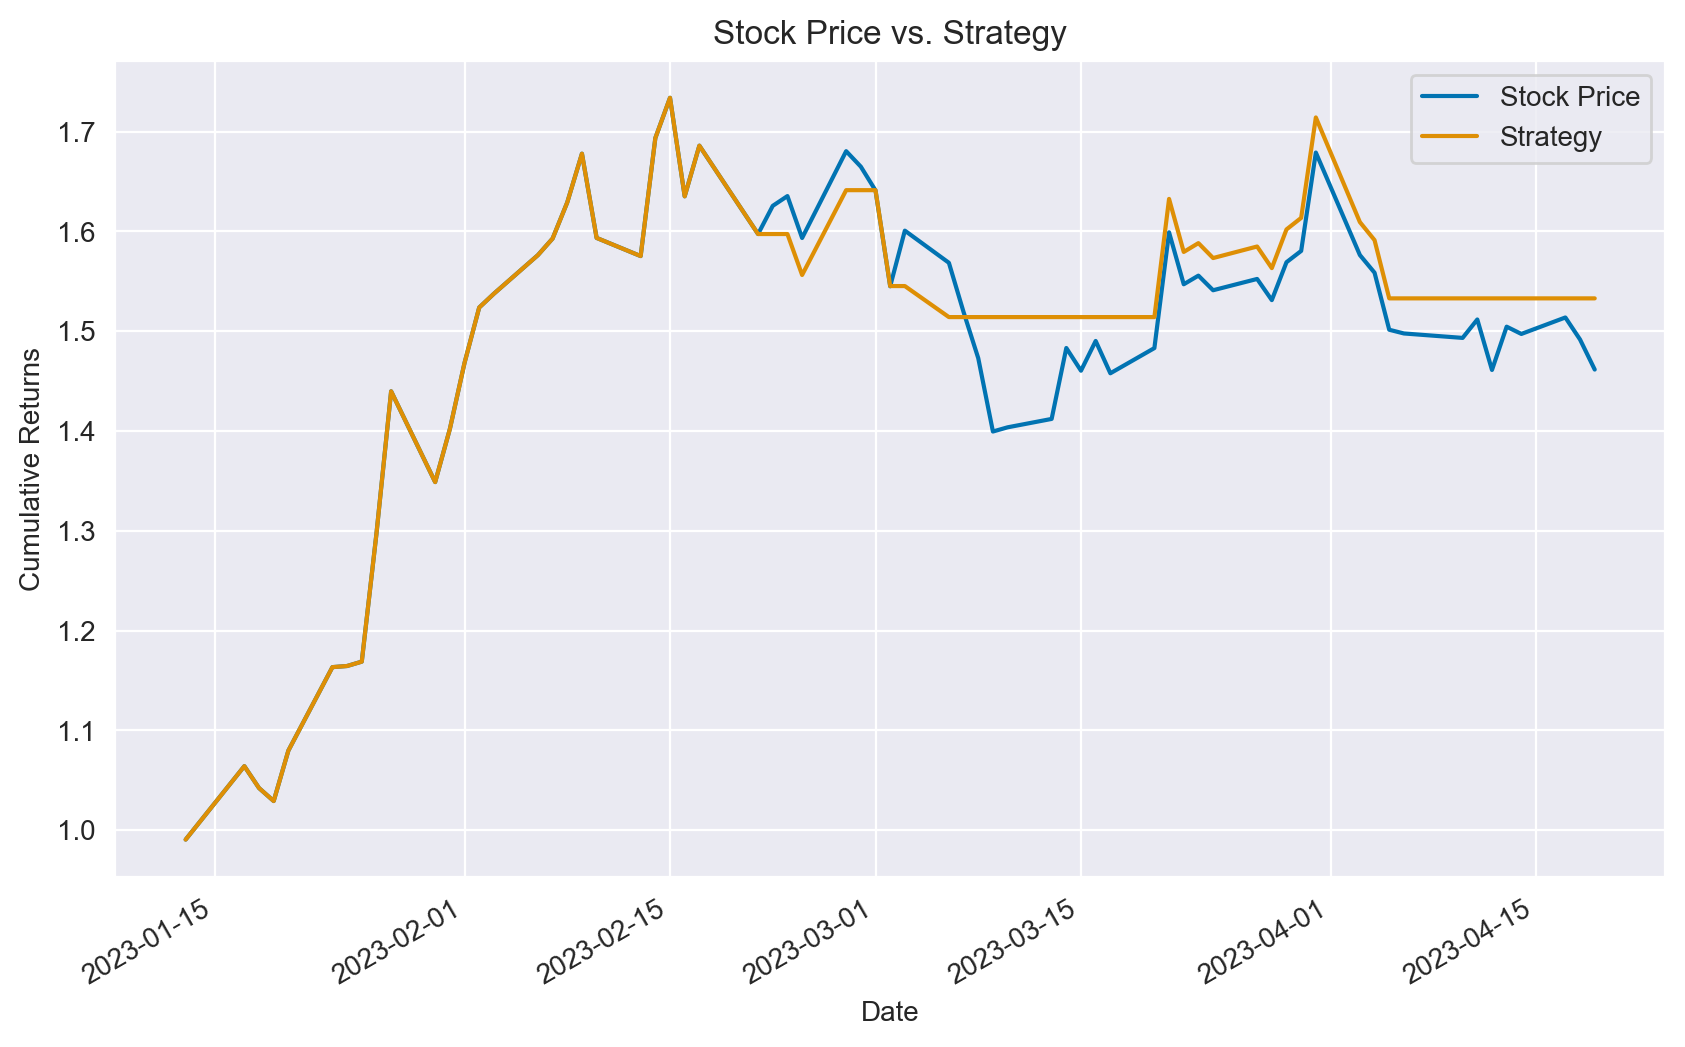

In [32]:
# Plot the data and set the legend label for 'return' to 'stock price'
ax = df[['return', 'strategy']].cumsum().apply(np.exp).plot(figsize=(10, 6))
ax.legend(['Stock Price', 'Strategy'])

# Set the axis labels and title
ax.set_xlabel('Date')
ax.set_ylabel('Cumulative Returns')
ax.set_title('Stock Price vs. Strategy')

In [33]:
df[['return', 'strategy']].cumsum().apply(np.exp).tail(1)

return  strategy
Date                          
2023-04-19  1.461557  1.532895

In [34]:
1.532895 - 1.461557

0.0713379999999999

- Strategy outperformed stock by 7%

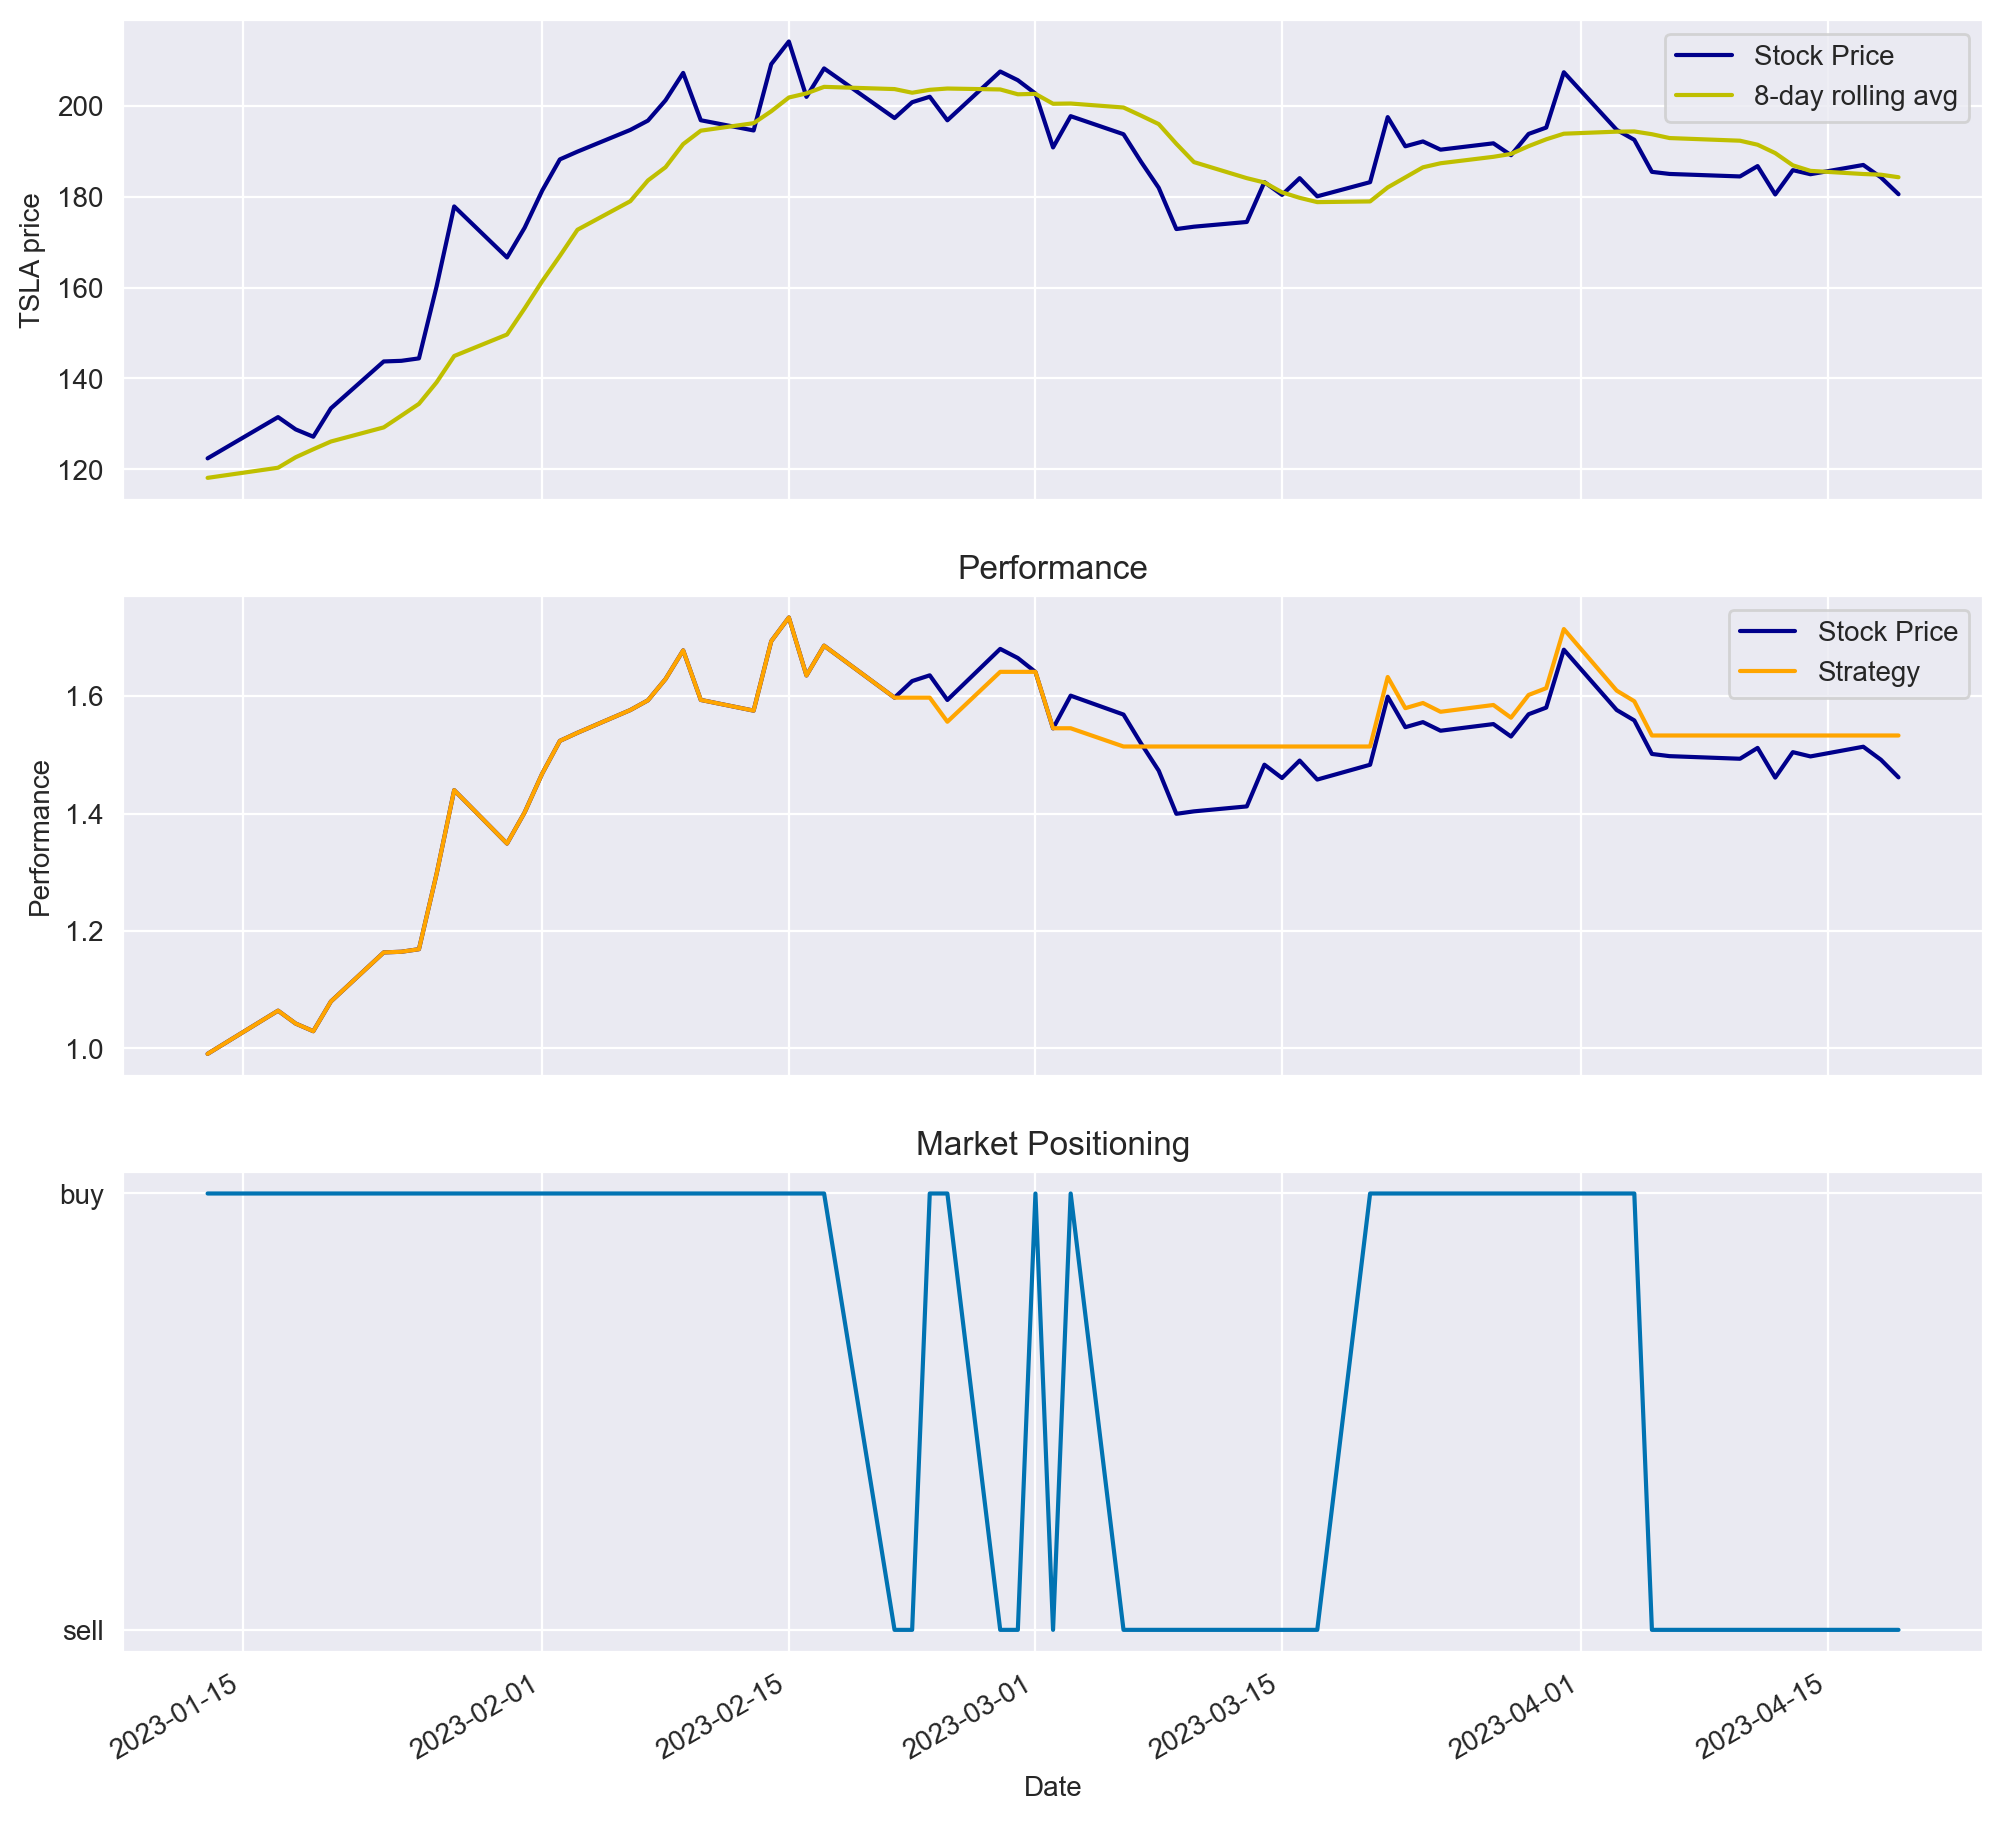

In [35]:
fig, ax = plt.subplots(3, 1, figsize=(12, 12), sharex=True)

df[['Adj Close', 'avg_mom']].plot(ax=ax[0], color=['darkblue', 'y'])
ax[0].set(ylabel="TSLA price", xlabel="Date")
ax[0].legend(['Stock Price', '8-day rolling avg'])

df[['return', 'strategy']].cumsum().apply(np.exp).plot(ax=ax[1], color=['darkblue', 'orange'])
ax[1].set(title='Performance')
ax[1].legend(['Stock Price', 'Strategy'])
ax[1].set_ylabel('Performance')

buy_sell_labels = {0.0: 'sell', 1.0: 'buy'}
df['position'].plot(ax=ax[2], title='Market Positioning')
_ = plt.yticks(list(buy_sell_labels.keys()), list(buy_sell_labels.values()))

### Linear Regression

In [36]:
# daily stock data with stock price, daily log return, and price lags of the returns
df = lag_day_df.copy()

# identify correct movement direction
df['actual'] = np.where(df['return'] > 0, 1, -1)
df.head()

price    return     lag_1     lag_2     lag_3     lag_4  \
Date                                                                       
2022-05-05  291.093323 -0.086960  0.046596  0.006964  0.036290 -0.007722   
2022-05-06  288.549988 -0.008776 -0.086960  0.046596  0.006964  0.036290   
2022-05-09  262.369995 -0.095113 -0.008776 -0.086960  0.046596  0.006964   
2022-05-10  266.679993  0.016294 -0.095113 -0.008776 -0.086960  0.046596   
2022-05-11  244.666672 -0.086153  0.016294 -0.095113 -0.008776 -0.086960   

               lag_5     lag_6     lag_7     lag_8     lag_9    lag_10  actual  
Date                                                                            
2022-05-05 -0.004548  0.005791 -0.129928 -0.007019 -0.003704  0.031806      -1  
2022-05-06 -0.007722 -0.004548  0.005791 -0.129928 -0.007019 -0.003704      -1  
2022-05-09  0.036290 -0.007722 -0.004548  0.005791 -0.129928 -0.007019      -1  
2022-05-10  0.006964  0.036290 -0.007722 -0.004548  0.005791 -0.129928       1  
2022-05-11  0.046596  0.006964  0.036290 -0.007722 -0.004548  0.005791      -1

In [37]:
# lag columns
cols = df.loc[:,'lag_1':'lag_10'].columns
df.dropna(inplace=True)

- Splitting and normalizing the data for machine learning:

In [38]:
cutoff = '2023-01-01'

In [39]:
# applying normal distribution
train = df[df.index < cutoff].copy()
mu, std = train.mean(), train.std()
train_ = (train - mu) / std

In [40]:
# with normal distribution
train_.head()

price    return     lag_1     lag_2     lag_3     lag_4  \
Date                                                                     
2022-05-05  1.149811 -1.946536  1.242506  0.310938  1.017758 -0.062053   
2022-05-06  1.096855 -0.073569 -1.943412  1.267627  0.310230  1.025729   
2022-05-09  0.551751 -2.141841 -0.078358 -1.956319  1.266410  0.300920   
2022-05-10  0.641491  0.526986 -2.137891 -0.069003 -1.955822  1.280454   
2022-05-11  0.183144 -1.927198  0.519659 -2.153120 -0.069510 -2.020477   

               lag_5     lag_6     lag_7     lag_8     lag_9    lag_10  \
Date                                                                     
2022-05-05  0.014438  0.259033 -3.036535 -0.053560  0.028323  0.892505   
2022-05-06 -0.064031 -0.000283  0.270476 -3.082518 -0.053367  0.016443   
2022-05-09  1.024067 -0.079890  0.018552  0.262131 -3.082351 -0.065335   
2022-05-10  0.299048  1.023991 -0.058786  0.007340  0.262327 -3.097589   
2022-05-11  1.278866  0.288456  1.013632 -0.070879  0.007533  0.250700   

              actual  
Date                  
2022-05-05 -0.950040  
2022-05-06 -0.950040  
2022-05-09 -0.950040  
2022-05-10  1.046246  
2022-05-11 -0.950040

In [41]:
# normalizing test data
test = df[df.index >= cutoff].copy()
test_ = (test - mu) / std

- Optimal regression parameters calculated with the ordinary least squares method:

In [42]:
# regression coefficients
reg_coef = np.linalg.lstsq(train_[cols], train['actual'], rcond=None)[0]
reg_coef

array([ 0.07212711,  0.00657657, -0.05541184, -0.00917131, -0.05895429,
        0.09369098,  0.107573  ,  0.04122745,  0.12941606, -0.18195405])

-  Predictions are calculated with Numpy's dot product function. It will return '-1' if the predicted return is negative and '1' if the predicted return is positive.

In [43]:
train['prediction'] = np.sign(np.dot(train_[cols], reg_coef))
train.head()

price    return     lag_1     lag_2     lag_3     lag_4  \
Date                                                                       
2022-05-05  291.093323 -0.086960  0.046596  0.006964  0.036290 -0.007722   
2022-05-06  288.549988 -0.008776 -0.086960  0.046596  0.006964  0.036290   
2022-05-09  262.369995 -0.095113 -0.008776 -0.086960  0.046596  0.006964   
2022-05-10  266.679993  0.016294 -0.095113 -0.008776 -0.086960  0.046596   
2022-05-11  244.666672 -0.086153  0.016294 -0.095113 -0.008776 -0.086960   

               lag_5     lag_6     lag_7     lag_8     lag_9    lag_10  \
Date                                                                     
2022-05-05 -0.004548  0.005791 -0.129928 -0.007019 -0.003704  0.031806   
2022-05-06 -0.007722 -0.004548  0.005791 -0.129928 -0.007019 -0.003704   
2022-05-09  0.036290 -0.007722 -0.004548  0.005791 -0.129928 -0.007019   
2022-05-10  0.006964  0.036290 -0.007722 -0.004548  0.005791 -0.129928   
2022-05-11  0.046596  0.006964  0.036290 -0.007722 -0.004548  0.005791   

            actual  prediction  
Date                            
2022-05-05      -1        -1.0  
2022-05-06      -1        -1.0  
2022-05-09      -1        -1.0  
2022-05-10       1         1.0  
2022-05-11      -1         1.0

In [44]:
accuracy_score(train['actual'], train['prediction'])

0.5843373493975904

In [45]:
success_rate = np.sign(train['return'] * train['prediction']).value_counts()
success_rate

success_pct = (success_rate.values[0] / sum(success_rate))
print(f'Correct on {success_pct:.0%} of predictions')

Correct on 58% of predictions


In [46]:
# convert short positions to closed
train['prediction'][train['prediction'] < 0] = 0

train['strategy'] = (train['prediction'] * train['return']) 

In [47]:
pct = train[['return', 'strategy']].sum().apply(np.exp)
pct

return      0.387920
strategy    0.886086
dtype: float64

In [48]:
print(f'Strategy outperformed stock by {(pct[1]-pct[0]).round(2)}')

Strategy outperformed stock by 0.5


Text(0.5, 1.0, 'Training Data')

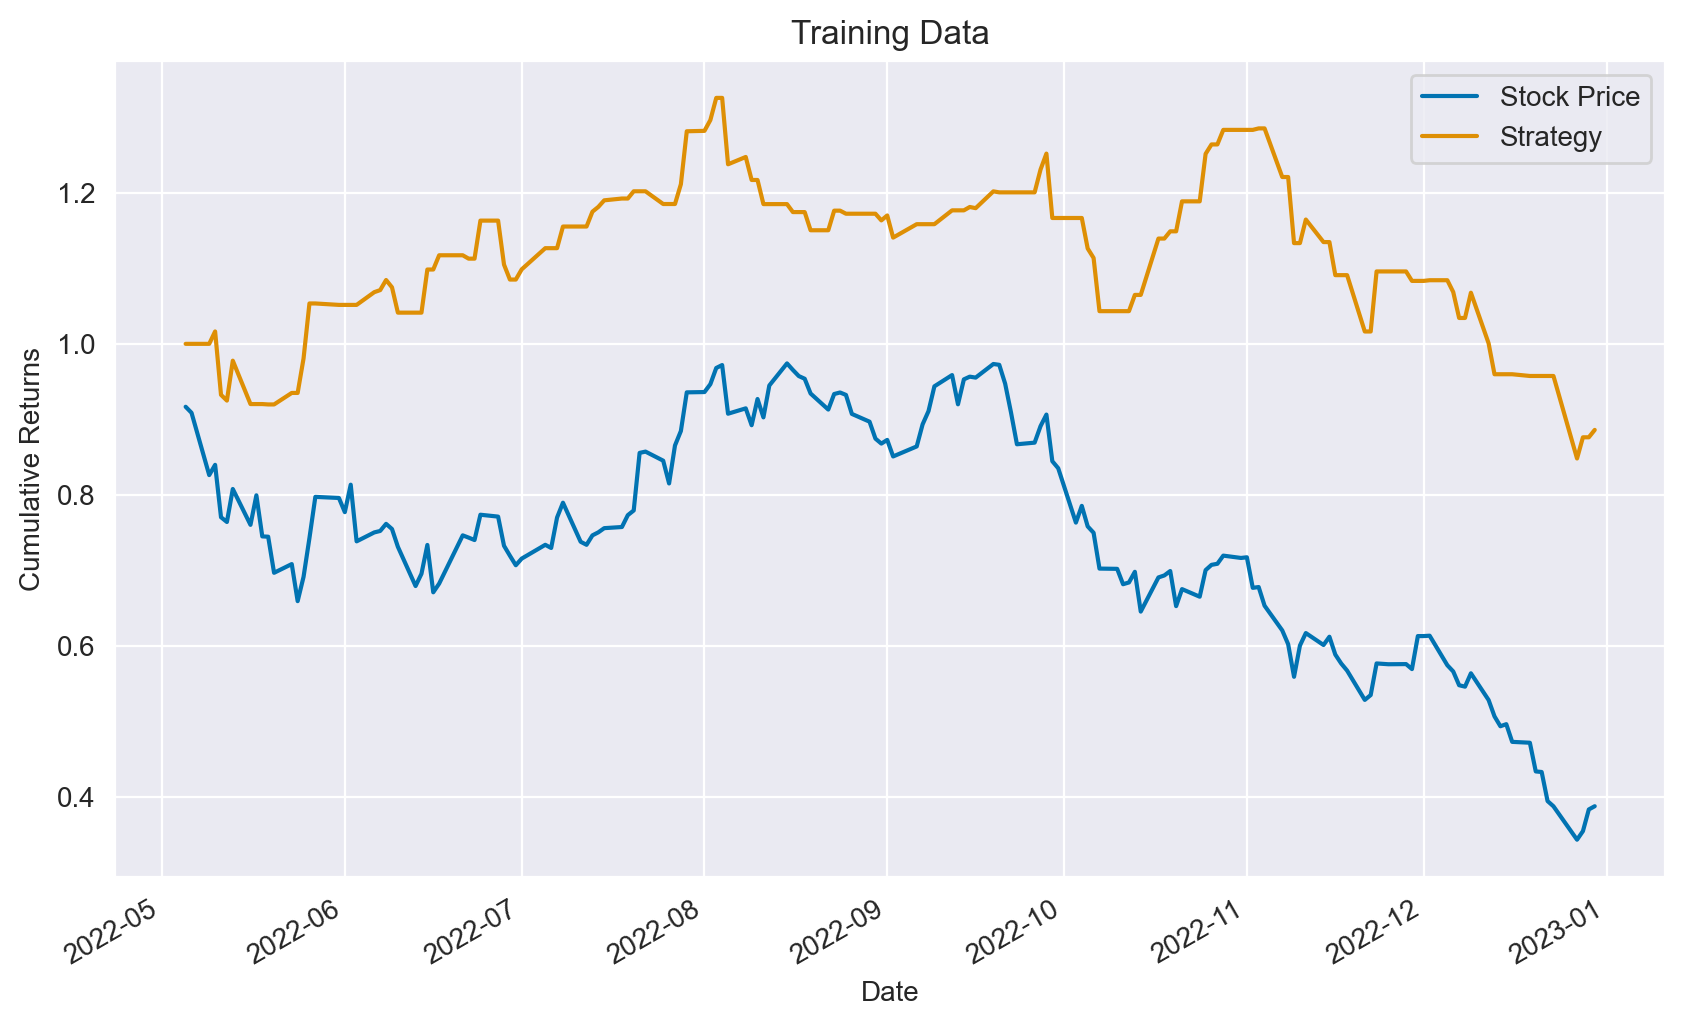

In [49]:
# Plot the data and set the legend label for 'return' to 'stock price'
ax = train[['return', 'strategy']].cumsum().apply(np.exp).plot(figsize=(10, 6))
ax.legend(['Stock Price', 'Strategy'])

# Set the axis labels and title
ax.set_xlabel('Date')
ax.set_ylabel('Cumulative Returns')
ax.set_title('Training Data')

- Test predictions are calculated as the sign of the dot product of normalized test columns and regression coefficients from the training data

In [50]:
test['prediction'] = np.sign(np.dot(test_[cols], reg_coef))
test.head()

price    return     lag_1     lag_2     lag_3     lag_4  \
Date                                                                       
2023-01-03  108.099998 -0.130590  0.011102  0.077726  0.032553 -0.121138   
2023-01-04  113.639999  0.049979 -0.130590  0.011102  0.077726  0.032553   
2023-01-05  110.339996 -0.029469  0.049979 -0.130590  0.011102  0.077726   
2023-01-06  113.059998  0.024352 -0.029469  0.049979 -0.130590  0.011102   
2023-01-09  119.769997  0.057655  0.024352 -0.029469  0.049979 -0.130590   

               lag_5     lag_6     lag_7     lag_8     lag_9    lag_10  \
Date                                                                     
2023-01-03 -0.017707 -0.093023 -0.001670 -0.083965 -0.002399 -0.048337   
2023-01-04 -0.121138 -0.017707 -0.093023 -0.001670 -0.083965 -0.002399   
2023-01-05  0.032553 -0.121138 -0.017707 -0.093023 -0.001670 -0.083965   
2023-01-06  0.077726  0.032553 -0.121138 -0.017707 -0.093023 -0.001670   
2023-01-09  0.011102  0.077726  0.032553 -0.121138 -0.017707 -0.093023   

            actual  prediction  
Date                            
2023-01-03      -1        -1.0  
2023-01-04       1        -1.0  
2023-01-05      -1        -1.0  
2023-01-06       1        -1.0  
2023-01-09       1         1.0

In [51]:
accuracy_score(test['actual'], test['prediction'])

0.5945945945945946

- The success rate is determined by multiplying the prediction by the actual return and analyzing the sign of the returned values (i.e. '1' indicates a correct prediction)

In [52]:
success_rate = np.sign(test['return'] * test['prediction']).value_counts()
success_rate

success_pct = (success_rate.values[0] / sum(success_rate))
print(f'Correct on {success_pct:.0%} of predictions')

Correct on 59% of predictions


- To visualize the performance, a 'strategy' column will be calculated 
- All short predictions ('-1') will be replace with zero to indicate selling the stock rather than shorting
- The 'strategy' value will be obtained by multiplying the 'prediction' with the 'return'

In [53]:
# convert short position to closed
test['prediction'][test['prediction'] < 0] = 0

test['strategy'] = (test['prediction'] * test['return'])

- The sum of 'return' & 'strategy' provides the total performance
- We're dealing with log returns so np.exp will also be applied

In [54]:
# performance summary
pct = test[['return', 'strategy']].sum().apply(np.exp)
pct

return      1.466066
strategy    1.575551
dtype: float64

In [55]:
print(f'Strategy outperformed stock by {(pct[1]-pct[0]).round(2)}')

Strategy outperformed stock by 0.11


Text(0.5, 1.0, 'Test Data')

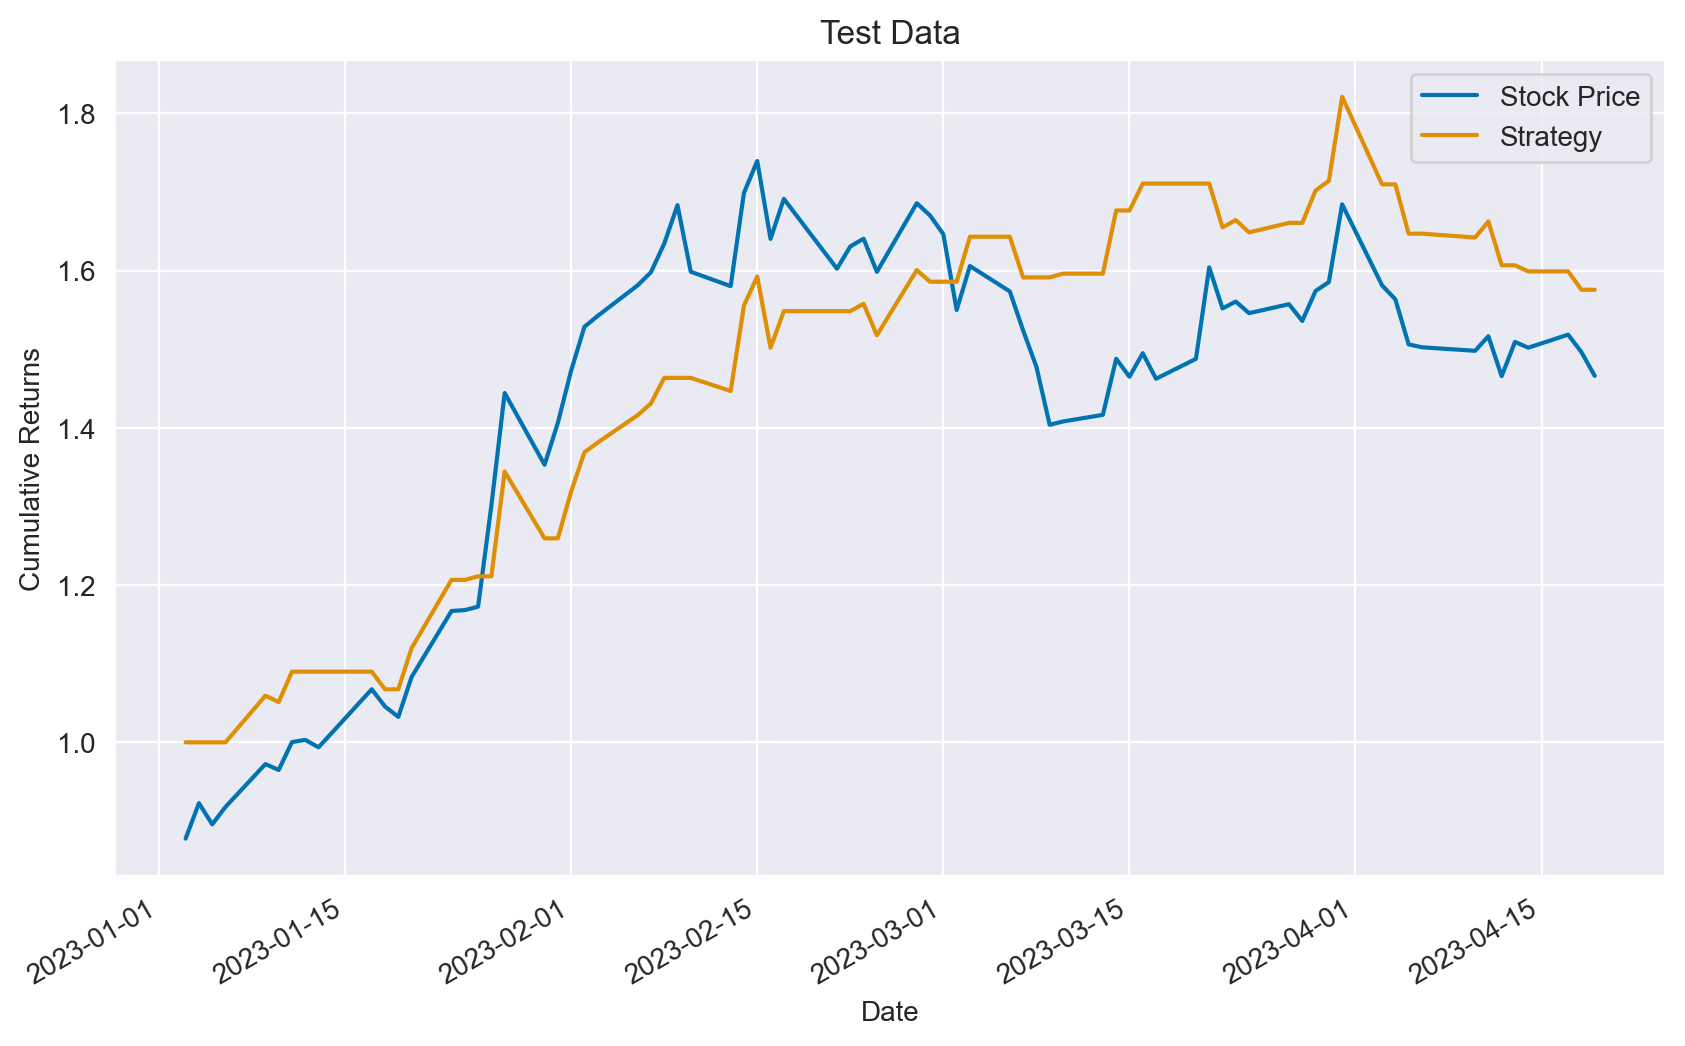

In [56]:
# Plot the data and set the legend label for 'return' to 'stock price'
ax = test[['return', 'strategy']].cumsum().apply(np.exp).plot(figsize=(10, 6))
ax.legend(['Stock Price', 'Strategy'])

# Set the axis labels and title
ax.set_xlabel('Date')
ax.set_ylabel('Cumulative Returns')
ax.set_title('Test Data')

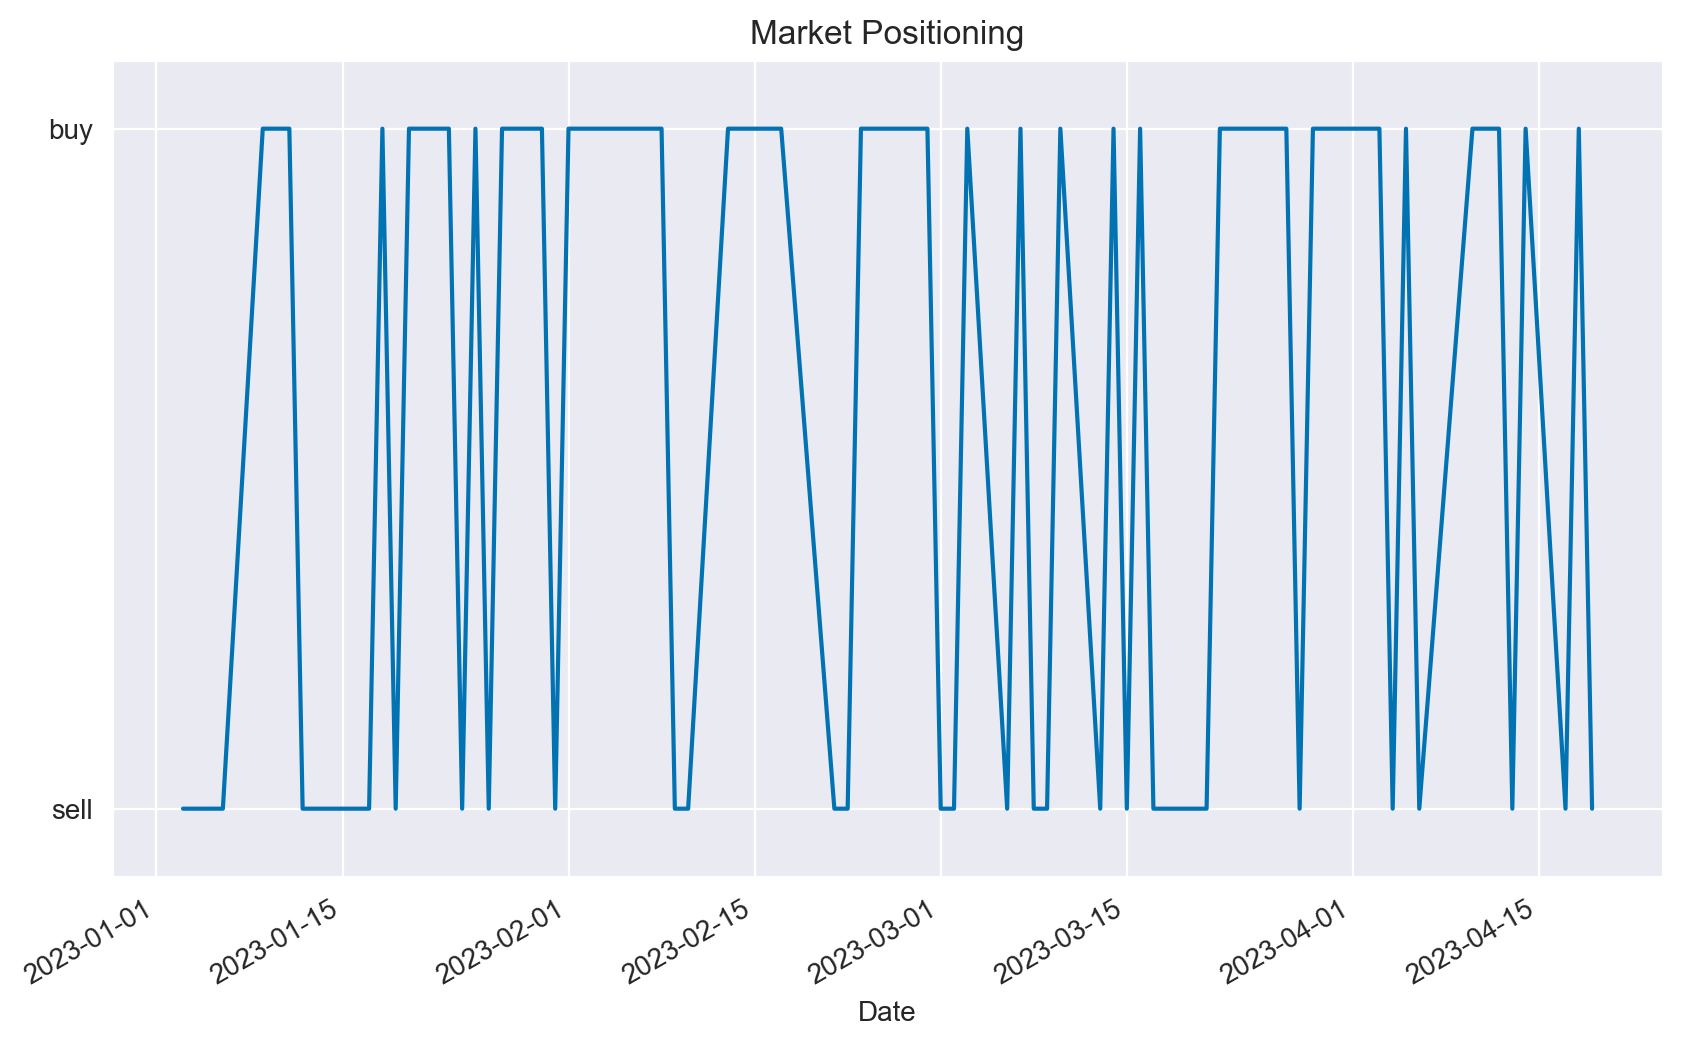

In [57]:
buy_sell_labels = {0.0: 'sell', 1.0: 'buy'}
ax = test['prediction'].plot(ylim=[-0.1, 1.1], title='Market Positioning', figsize=(10, 6))
_ = plt.yticks(list(buy_sell_labels.keys()), list(buy_sell_labels.values()))

- Much more buy/sell action with this technique

In [58]:
train[['return']].loc[:'2022-12-30'].sum().apply(np.exp)

return    0.38792
dtype: float64

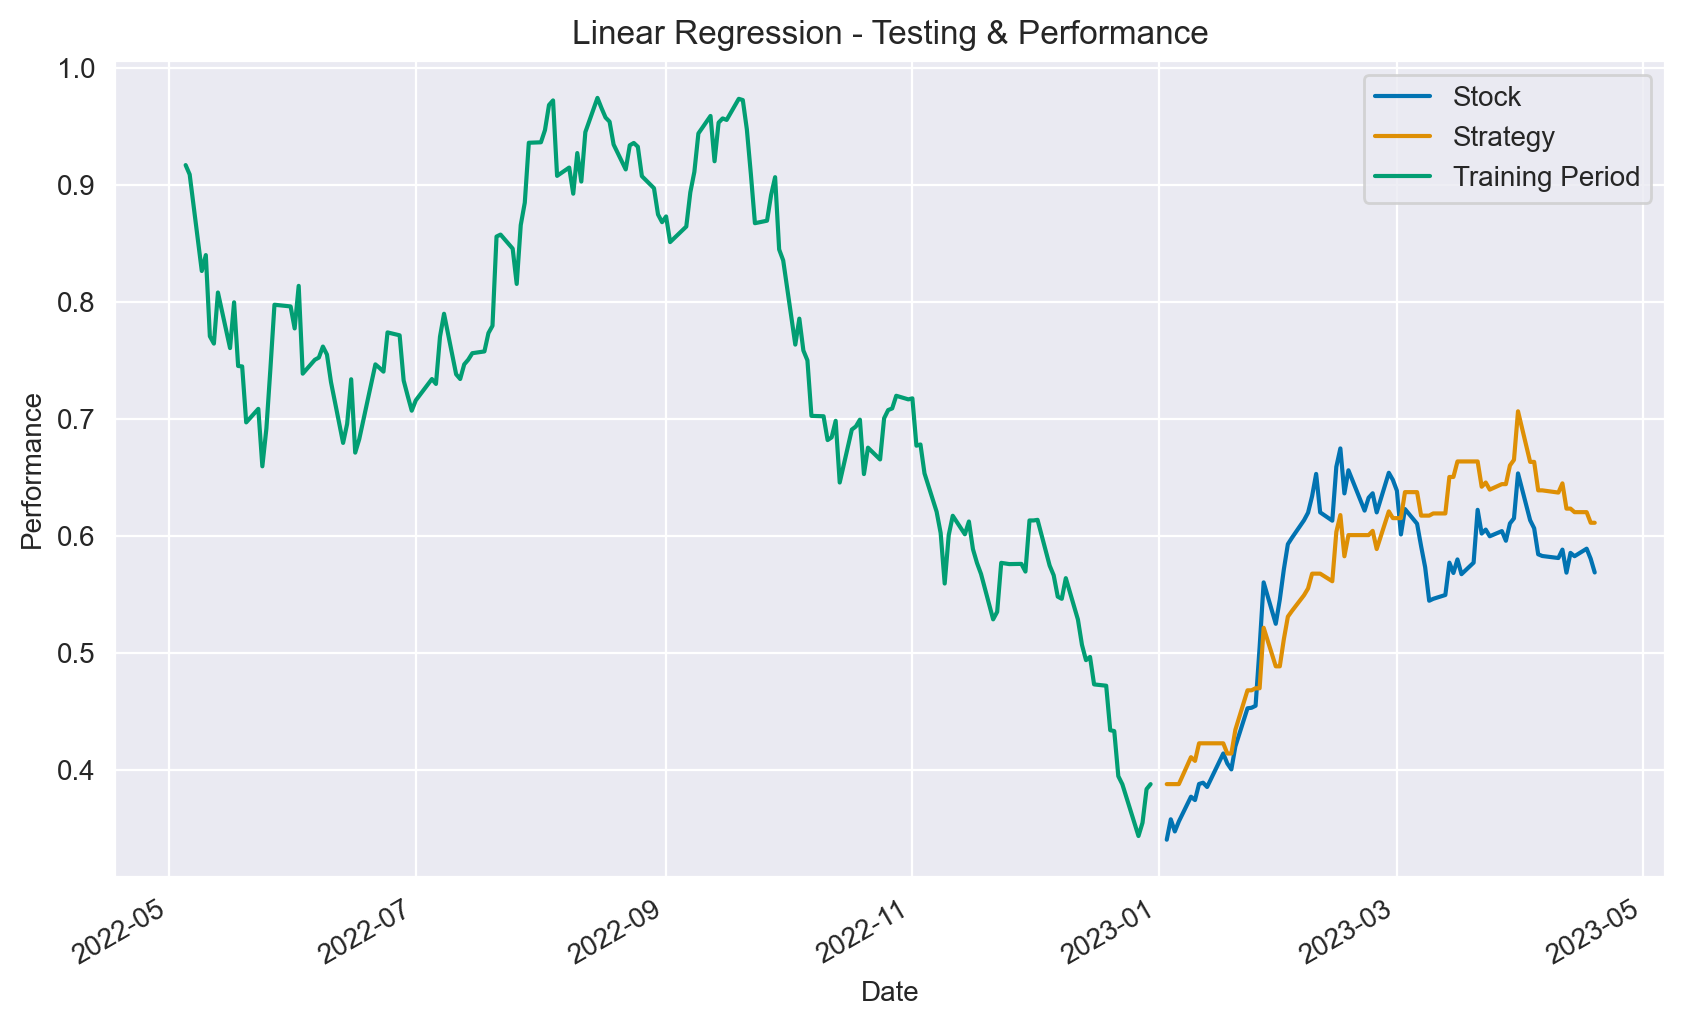

In [59]:
fig, ax = plt.subplots()

# performance plot
data = test[['return', 'strategy']].cumsum().apply(np.exp) 

# scale to match training data end point 
scaled_data = data * 0.38792

# plot scaled data
scaled_data.plot(ax=ax)

# training data plot
train[['return']].cumsum().apply(np.exp).plot(ax=ax, figsize=(10, 6))

ax.set_xlabel('Date')
ax.set_ylabel('Performance')
ax.set_title('Linear Regression - Testing & Performance')
ax.legend(['Stock', 'Strategy', 'Training Period'])

### Logistic Regression

In [60]:
# daily stock data with price lags & log returns
df = lag_day_df.copy()
df['actual'] = np.where(df['return'] > 0, 1, -1)

In [61]:
cols

Index(['lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6', 'lag_7', 'lag_8',
       'lag_9', 'lag_10'],
      dtype='object')

In [62]:
# C=1e7 eliminates regularization; 
# solver specifies algorithm as lbfgs; 
# auto multi_class selects strategy based on data;
# 1000 max_iter to ensure enough iterations
model = LogisticRegression(C=1e7, solver='lbfgs', multi_class='auto', max_iter=1000)

- Splitting and normalizing the data for machine learning:

In [63]:
cutoff = '2023-01-01'

In [64]:
train = df[df.index < cutoff].copy()
mu, std = train.mean(), train.std()
train_ = (train - mu) / std

In [65]:
test = df[df.index >= cutoff].copy()
test_ = (test - mu) / std

- Fitting & evaluation:

In [66]:
# fit with lag columns & actual price direction
model.fit(train_[cols], train['actual'])

LogisticRegression(C=10000000.0, max_iter=1000)

In [67]:
accuracy_score(train['actual'], model.predict(train_[cols]))

0.5963855421686747

In [68]:
train['prediction'] = model.predict(train_[cols])

In [69]:
success_rate = np.sign(train['return'] * train['prediction']).value_counts()
success_rate

success_pct = (success_rate.values[0] / sum(success_rate))
print(f'Correct on {success_pct:.0%} of predictions')

Correct on 59% of predictions


In [70]:
# convert short positions to closed
train['prediction'][train['prediction'] < 0] = 0
train['strategy'] = (train['prediction'] * train['return']) 

In [71]:
# performance summary
pct = train[['return', 'strategy']].sum().apply(np.exp)
pct

return      0.387920
strategy    1.024418
dtype: float64

In [72]:
print(f'Strategy outperformed stock by {(pct[1]-pct[0]).round(2)}')

Strategy outperformed stock by 0.64


Text(0.5, 1.0, 'Training Data')

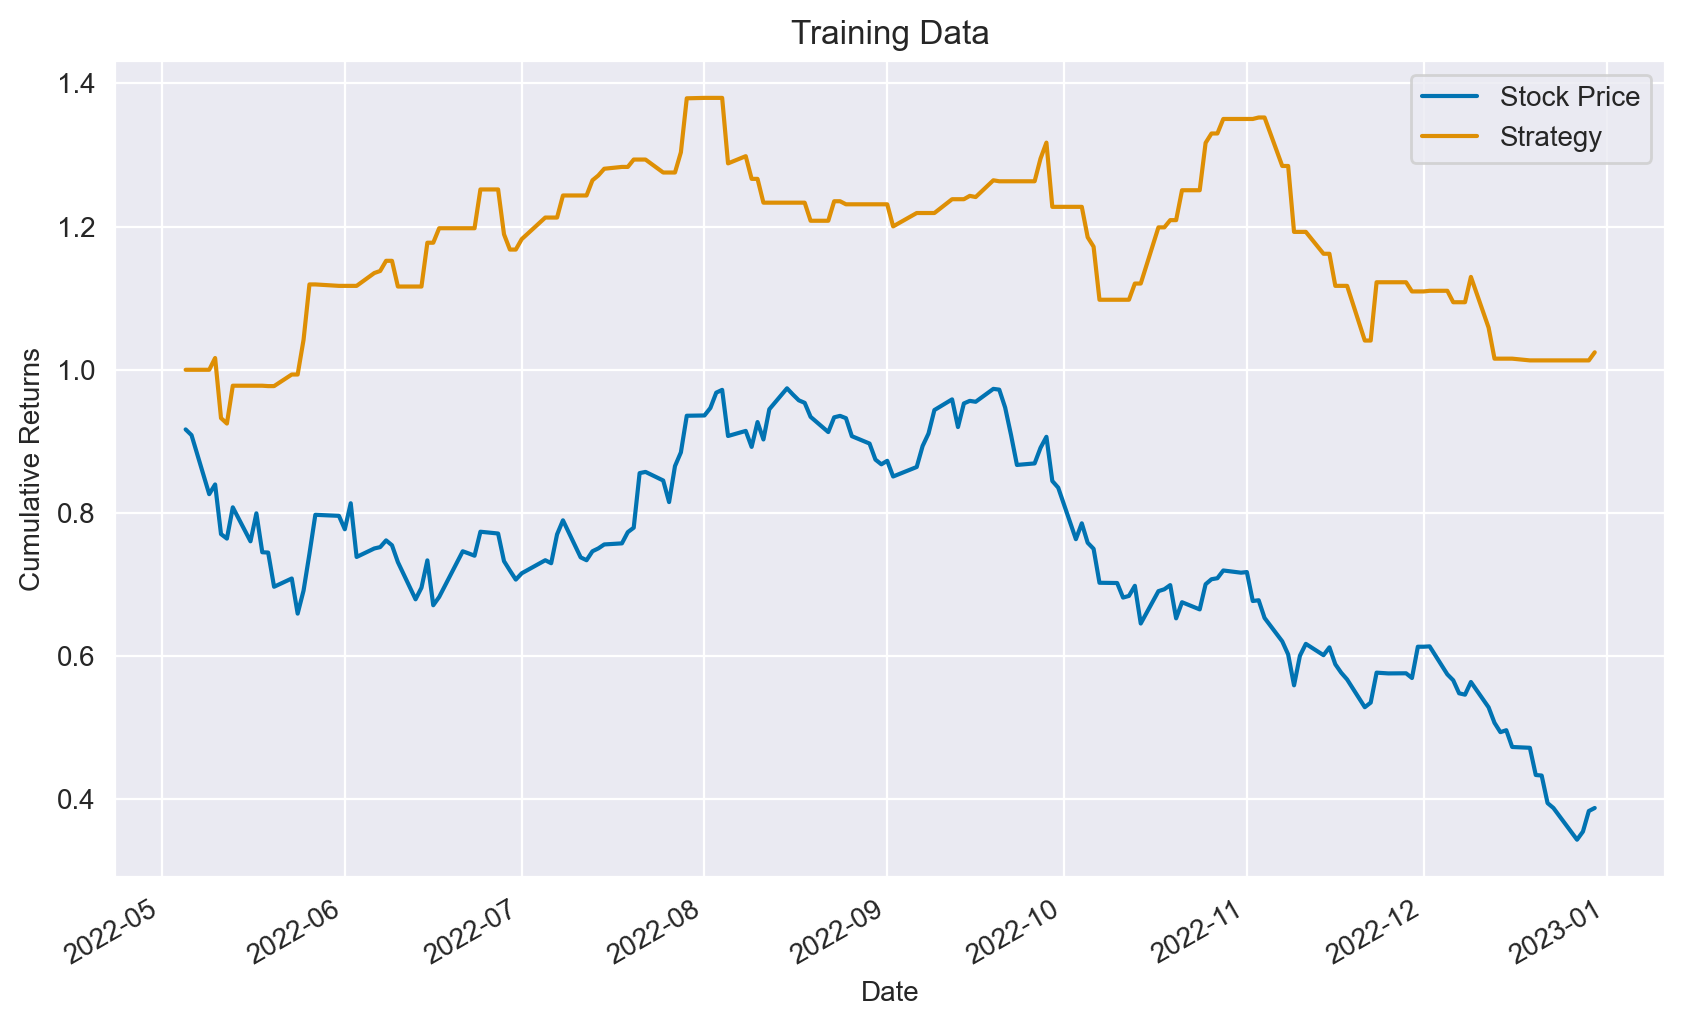

In [73]:
# Plot the data and set the legend label for 'return' to 'stock price'
ax = train[['return', 'strategy']].cumsum().apply(np.exp).plot(figsize=(10, 6))
ax.legend(['Stock Price', 'Strategy'])

# Set the axis labels and title
ax.set_xlabel('Date')
ax.set_ylabel('Cumulative Returns')
ax.set_title('Training Data')

In [74]:
test['prediction'] = model.predict(test_[cols])

In [75]:
accuracy_score(test['actual'], test['prediction'])

0.6081081081081081

In [76]:
success_rate = np.sign(test['return'] * test['prediction']).value_counts()
success_pct = (success_rate.values[0] / sum(success_rate))
print(f'Correct on {success_pct:.0%} of predictions')

Correct on 61% of predictions


In [77]:
test['prediction'][test['prediction'] < 0] = 0
test['strategy'] = (test['prediction'] * test['return'])

In [78]:
# performance summary
pct = test[['return', 'strategy']].sum().apply(np.exp)
pct

return      1.466066
strategy    1.619833
dtype: float64

In [79]:
print(f'Strategy outperformed stock by {(pct[1]-pct[0]).round(2)}')

Strategy outperformed stock by 0.15


Text(0.5, 1.0, 'Test Data')

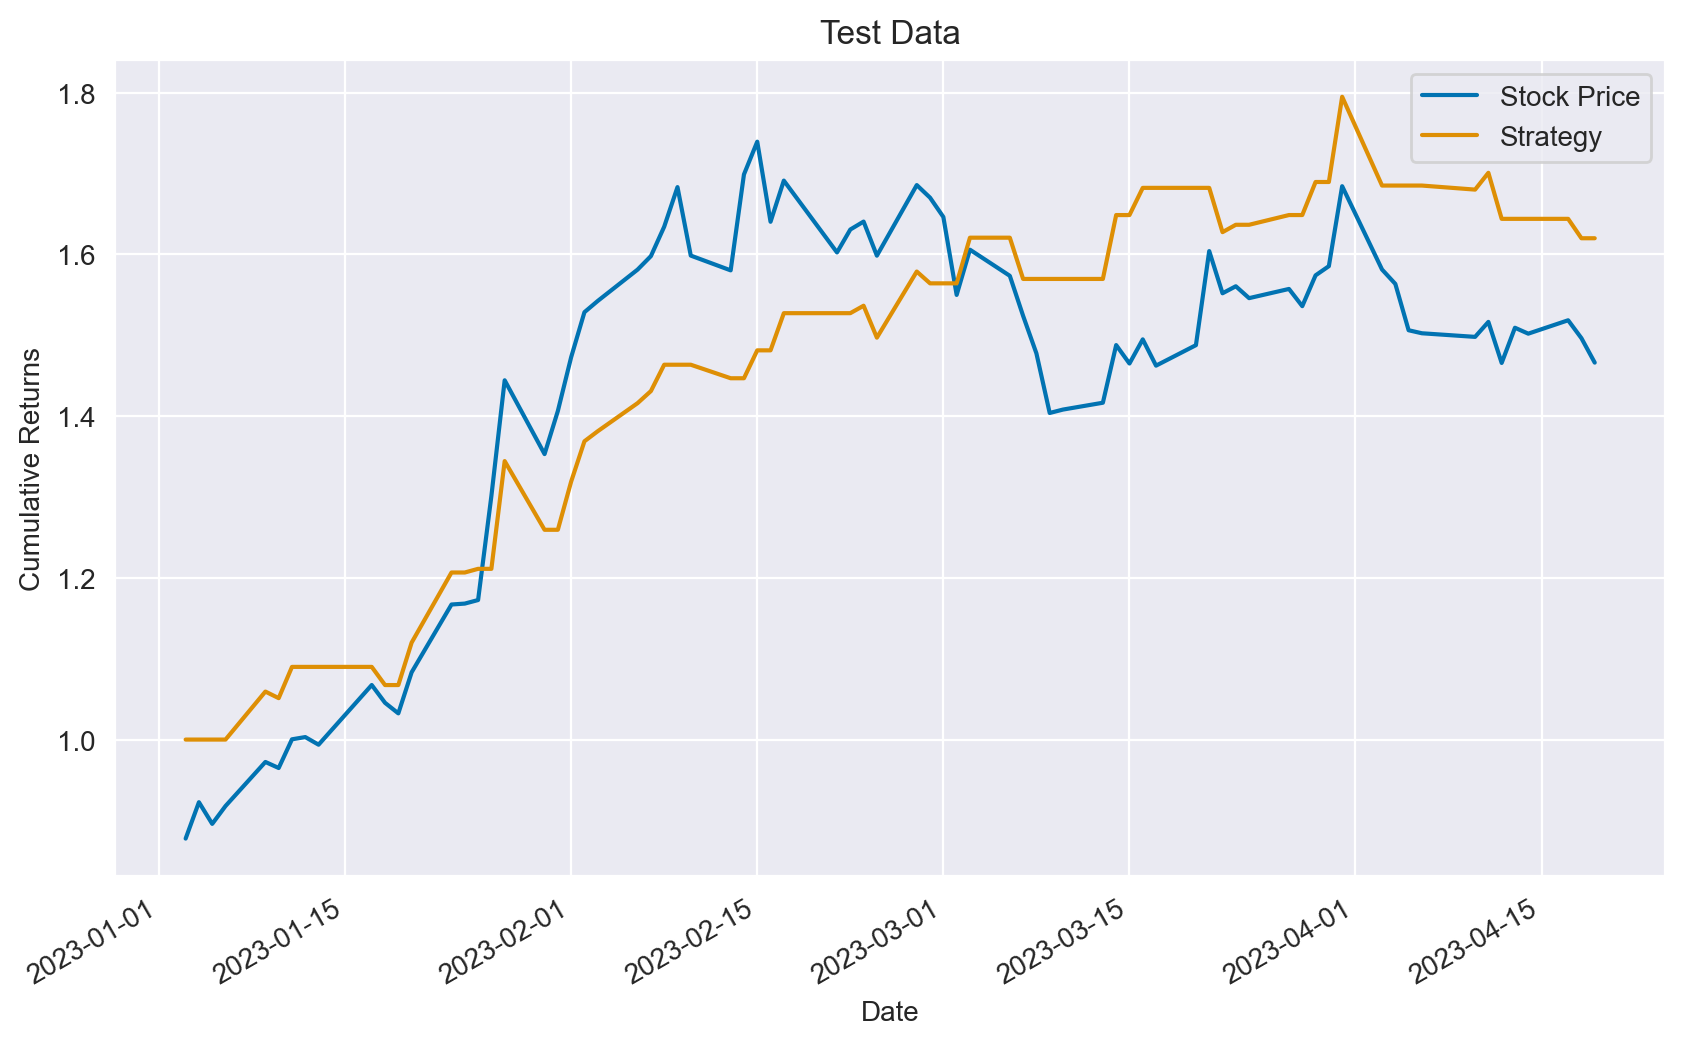

In [80]:
# Plot the data and set the legend label for 'return' to 'stock price'
ax = test[['return', 'strategy']].cumsum().apply(np.exp).plot(figsize=(10, 6))
ax.legend(['Stock Price', 'Strategy'])

# Set the axis labels and title
ax.set_xlabel('Date')
ax.set_ylabel('Cumulative Returns')
ax.set_title('Test Data')

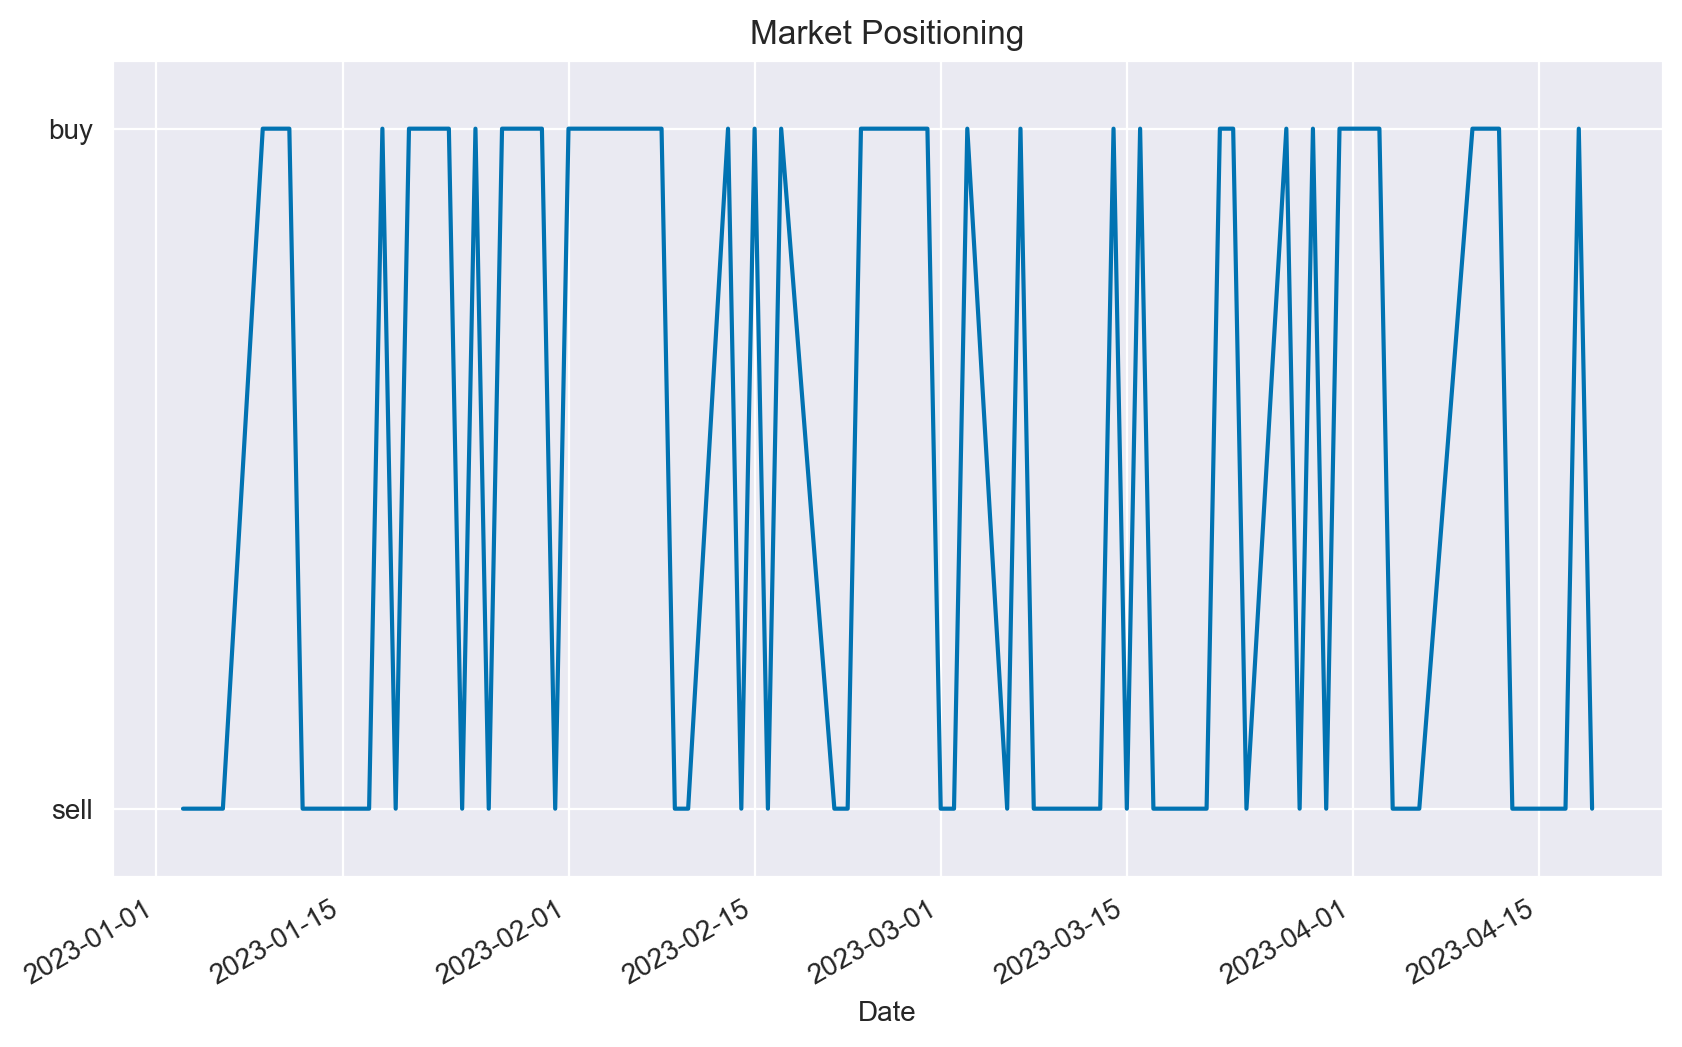

In [81]:
buy_sell_labels = {0.0: 'sell', 1.0: 'buy'}
ax = test['prediction'].plot(ylim=[-0.1, 1.1], title='Market Positioning', figsize=(10, 6))
_ = plt.yticks(list(buy_sell_labels.keys()), list(buy_sell_labels.values()))

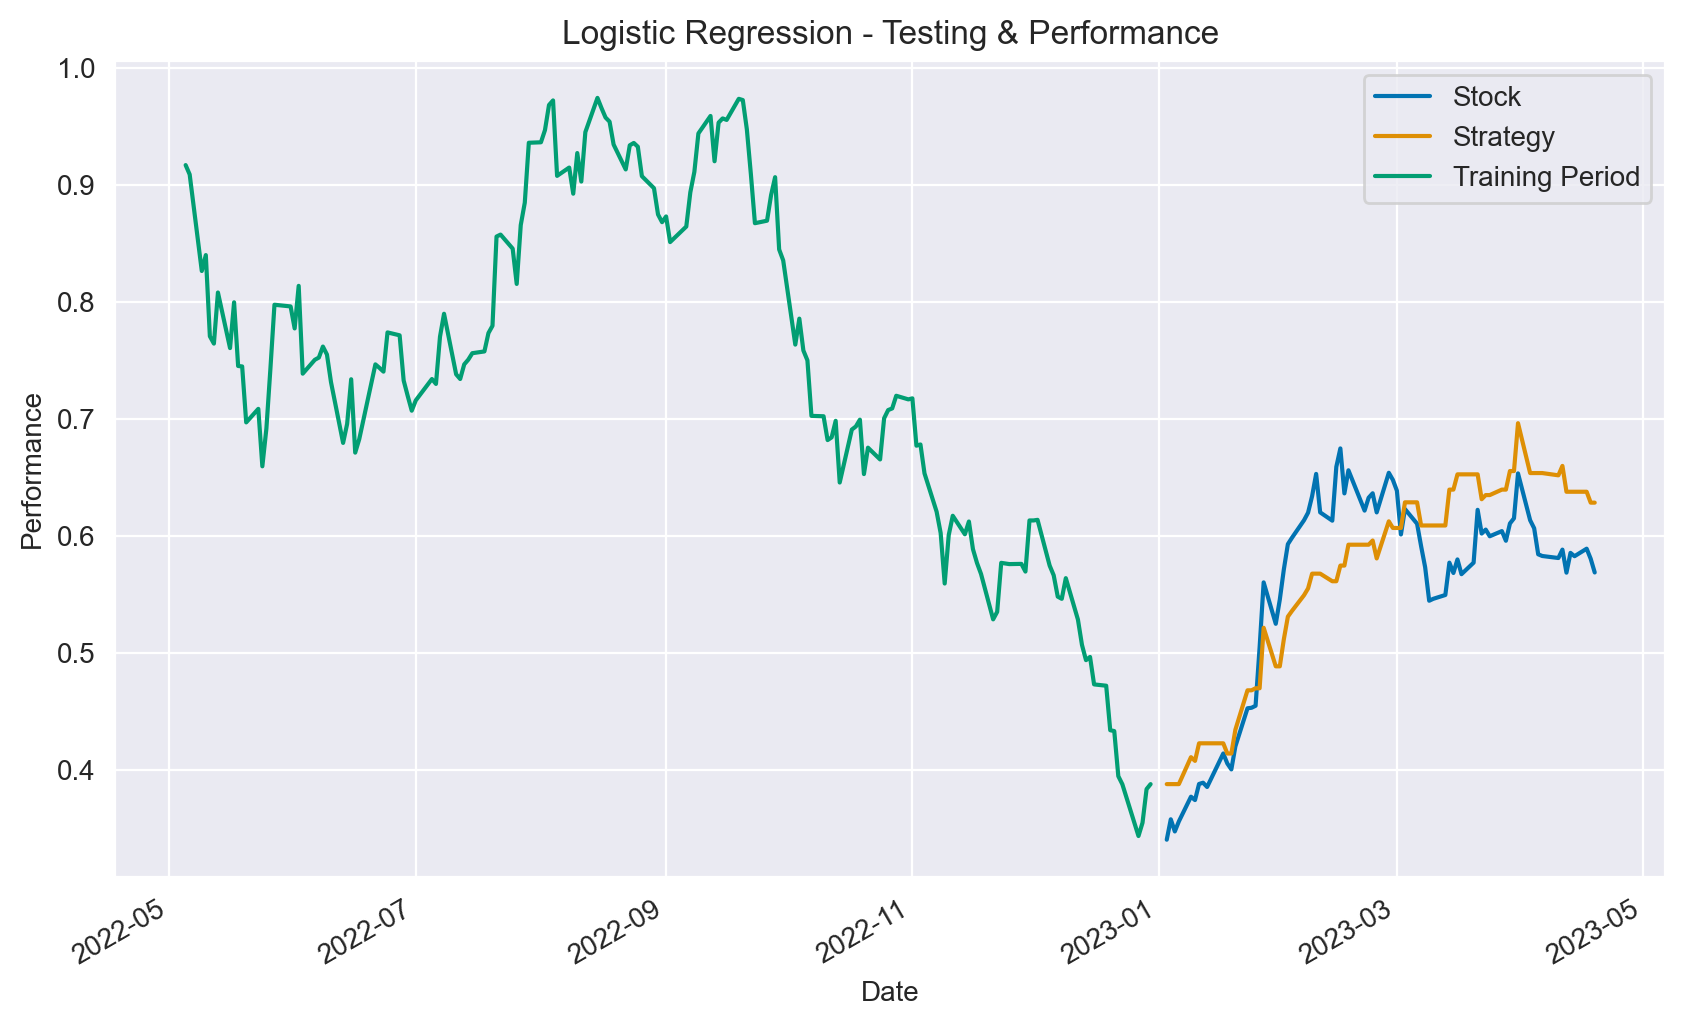

In [82]:
fig, ax = plt.subplots()

# performance plot
data = test[['return', 'strategy']].cumsum().apply(np.exp) 

# scale to match training data end point 
scaled_data = data * 0.38792

# plot scaled data
scaled_data.plot(ax=ax)

# training data plot
train[['return']].cumsum().apply(np.exp).plot(ax=ax, figsize=(10, 6))

ax.set_xlabel('Date')
ax.set_ylabel('Performance')
ax.set_title('Logistic Regression - Testing & Performance')
ax.legend(['Stock', 'Strategy', 'Training Period'])

### Deep Learning

In [83]:
df = lag_day_df.copy()
df['actual'] = np.where(df['return'] > 0, 1, 0)
df.head()

price    return     lag_1     lag_2     lag_3     lag_4  \
Date                                                                       
2022-05-05  291.093323 -0.086960  0.046596  0.006964  0.036290 -0.007722   
2022-05-06  288.549988 -0.008776 -0.086960  0.046596  0.006964  0.036290   
2022-05-09  262.369995 -0.095113 -0.008776 -0.086960  0.046596  0.006964   
2022-05-10  266.679993  0.016294 -0.095113 -0.008776 -0.086960  0.046596   
2022-05-11  244.666672 -0.086153  0.016294 -0.095113 -0.008776 -0.086960   

               lag_5     lag_6     lag_7     lag_8     lag_9    lag_10  actual  
Date                                                                            
2022-05-05 -0.004548  0.005791 -0.129928 -0.007019 -0.003704  0.031806       0  
2022-05-06 -0.007722 -0.004548  0.005791 -0.129928 -0.007019 -0.003704       0  
2022-05-09  0.036290 -0.007722 -0.004548  0.005791 -0.129928 -0.007019       0  
2022-05-10  0.006964  0.036290 -0.007722 -0.004548  0.005791 -0.129928       1  
2022-05-11  0.046596  0.006964  0.036290 -0.007722 -0.004548  0.005791       0

- Setting deep learning parameters

In [84]:
cols = df.loc[:,'lag_1':'lag_10'].columns

# low learning rate to minimize overfitting
optimizer = Adam(learning_rate=0.0001)

In [85]:
def set_seeds(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(42)

In [86]:
set_seeds()
model = Sequential()

# dense layers
model.add(Dense(64, activation='relu', input_shape=(len(cols),)))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# binary classification problems use: loss='binary_crossentropy' 
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

- Splitting data into train & test sets for machine learning

In [87]:
cutoff = '2023-01-01'

In [88]:
train = df[df.index < cutoff].copy()
mu, std = train.mean(), train.std()
train_ = (train - mu) / std

In [89]:
test = df[df.index >= cutoff].copy()
test_ = (test - mu) / std

- Fitting & evaluation:

In [90]:
model.fit(train[cols], train['actual'], epochs=50, verbose=False, validation_split=0.3, shuffle=False)

In [91]:
model.evaluate(train_[cols], train['actual'])

6/6 [==============================] - 0s 3ms/step - loss: 0.6550 - accuracy: 0.6145


[0.6549695134162903, 0.6144578456878662]

In [92]:
pred = np.where(model.predict(train_[cols]) > 0.5, 1, 0)

6/6 [==============================] - 0s 3ms/step


In [93]:
train['prediction'] = np.where(pred > 0, 1, 0)

In [94]:
train['strategy'] = (train['prediction'] * train['return']) 

In [95]:
# performance summary
pct = train[['return', 'strategy']].sum().apply(np.exp)
pct

return      0.387920
strategy    1.519254
dtype: float64

In [96]:
print(f'Strategy outperformed stock by {(pct[1]-pct[0]).round(2)}')

Strategy outperformed stock by 1.13


Text(0.5, 1.0, 'Training Data')

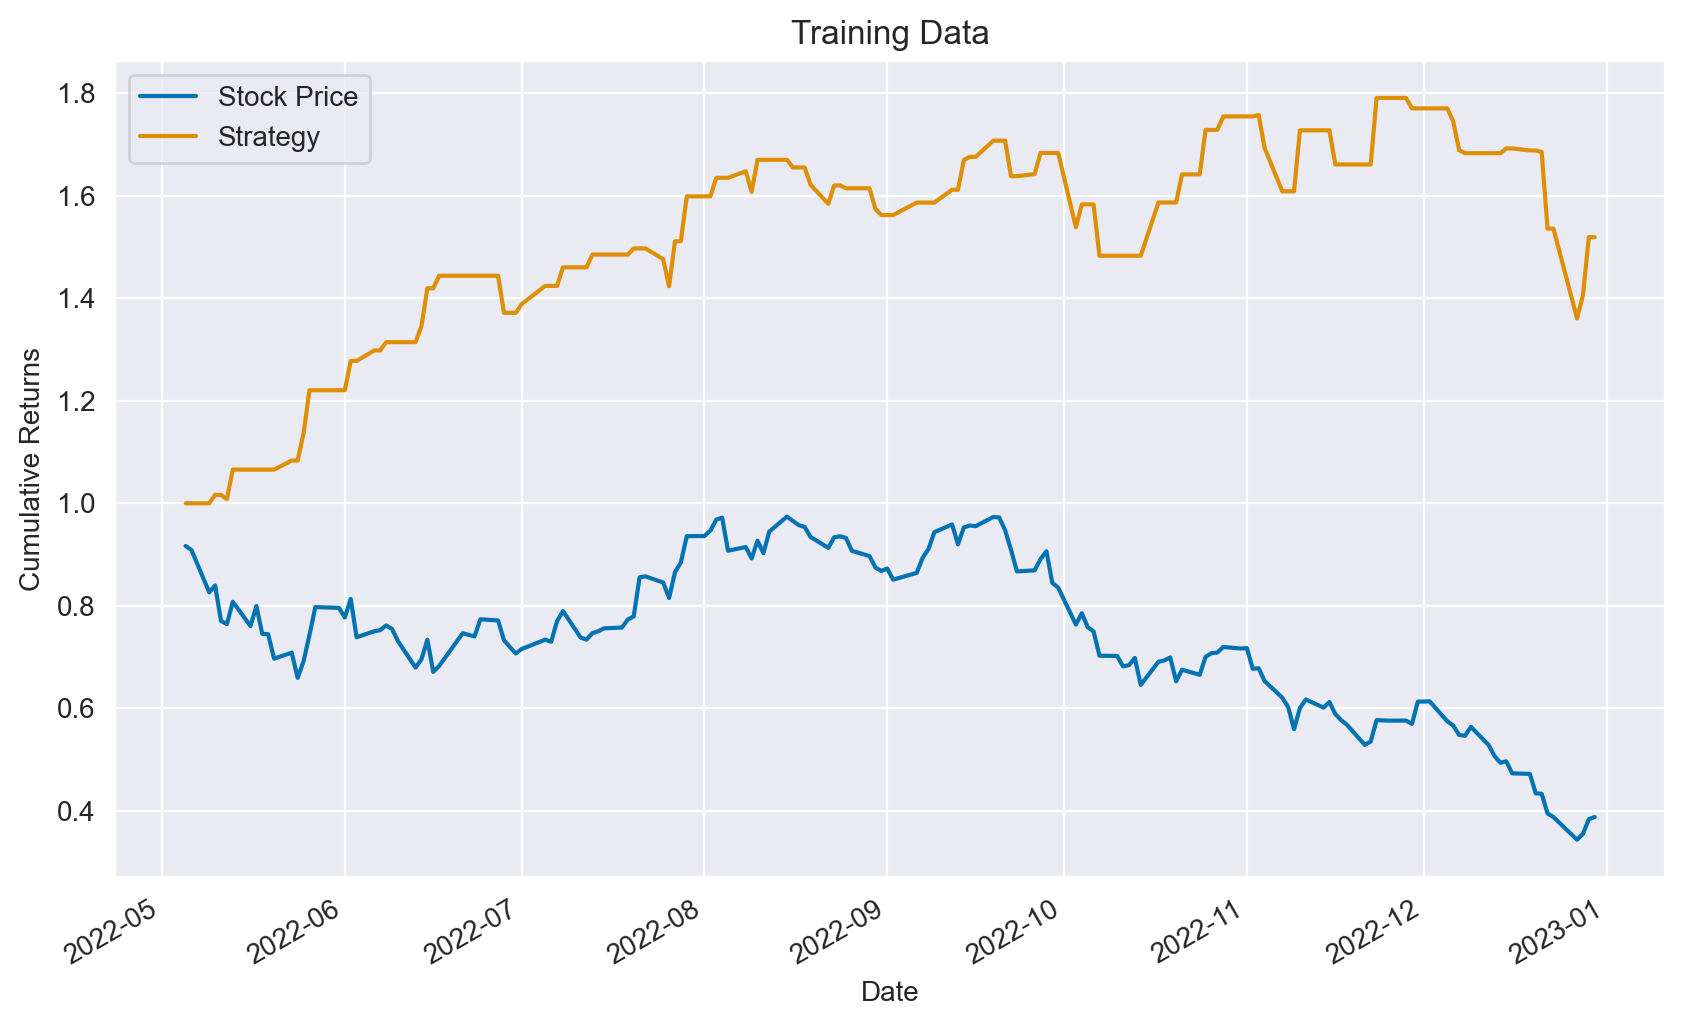

In [97]:
# Plot the data and set the legend label for 'return' to 'stock price'
ax = train[['return', 'strategy']].cumsum().apply(np.exp).plot(figsize=(10, 6))
ax.legend(['Stock Price', 'Strategy'])

# Set the axis labels and title
ax.set_xlabel('Date')
ax.set_ylabel('Cumulative Returns')
ax.set_title('Training Data')

In [98]:
# now on test data
model.evaluate(test_[cols], test['actual'])

3/3 [==============================] - 0s 7ms/step - loss: 0.7118 - accuracy: 0.5541


[0.7117818593978882, 0.5540540814399719]

In [99]:
pred = np.where(model.predict(test_[cols]) > 0.5, 1, 0)

3/3 [==============================] - 0s 6ms/step


In [100]:
test['prediction'] = np.where(pred > 0, 1, 0)

In [101]:
test['prediction'].value_counts()

0    44
1    30
Name: prediction, dtype: int64

In [102]:
test['strategy'] = (test['prediction'] * test['return'])

In [103]:
# performance summary
pct = test[['return', 'strategy']].sum().apply(np.exp)
pct

return      1.466066
strategy    1.445734
dtype: float64

In [104]:
print(f'Strategy outperformed stock by {(pct[1]-pct[0]).round(2)}')

Strategy outperformed stock by -0.02


Text(0.5, 1.0, 'Test Data')

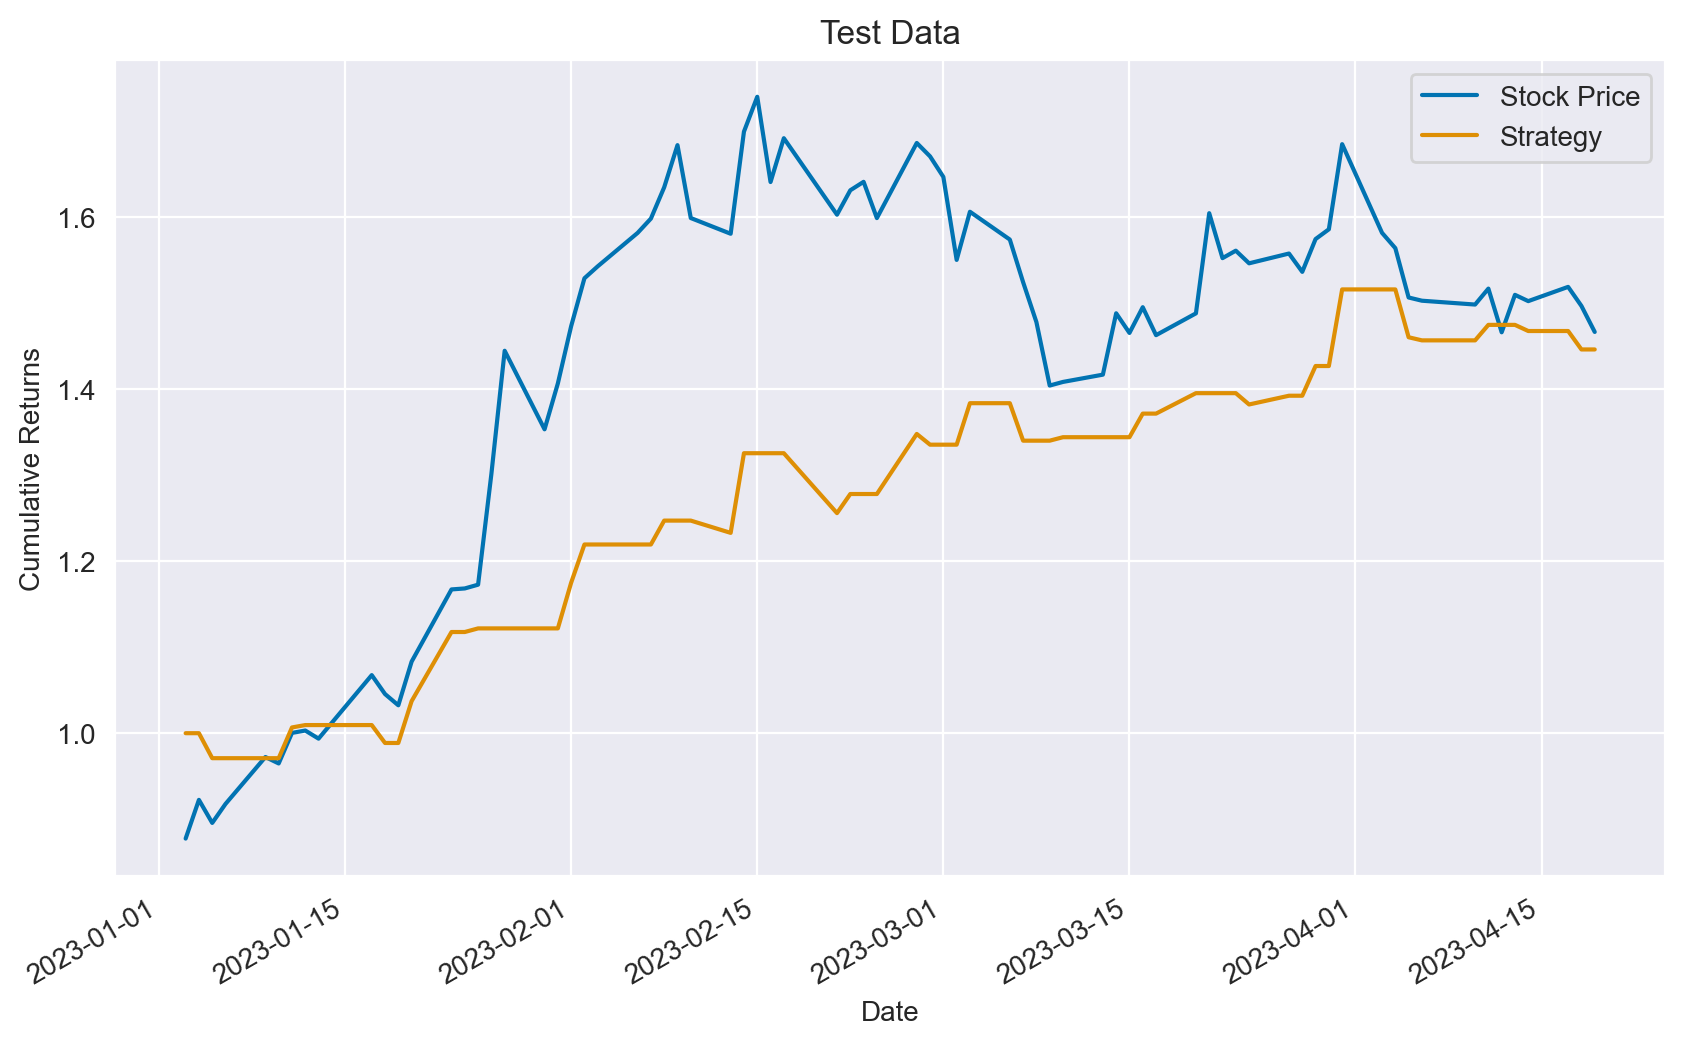

In [105]:
# Plot the data and set the legend label for 'return' to 'stock price'
ax = test[['return', 'strategy']].cumsum().apply(np.exp).plot(figsize=(10, 6))
ax.legend(['Stock Price', 'Strategy'])

# Set the axis labels and title
ax.set_xlabel('Date')
ax.set_ylabel('Cumulative Returns')
ax.set_title('Test Data')

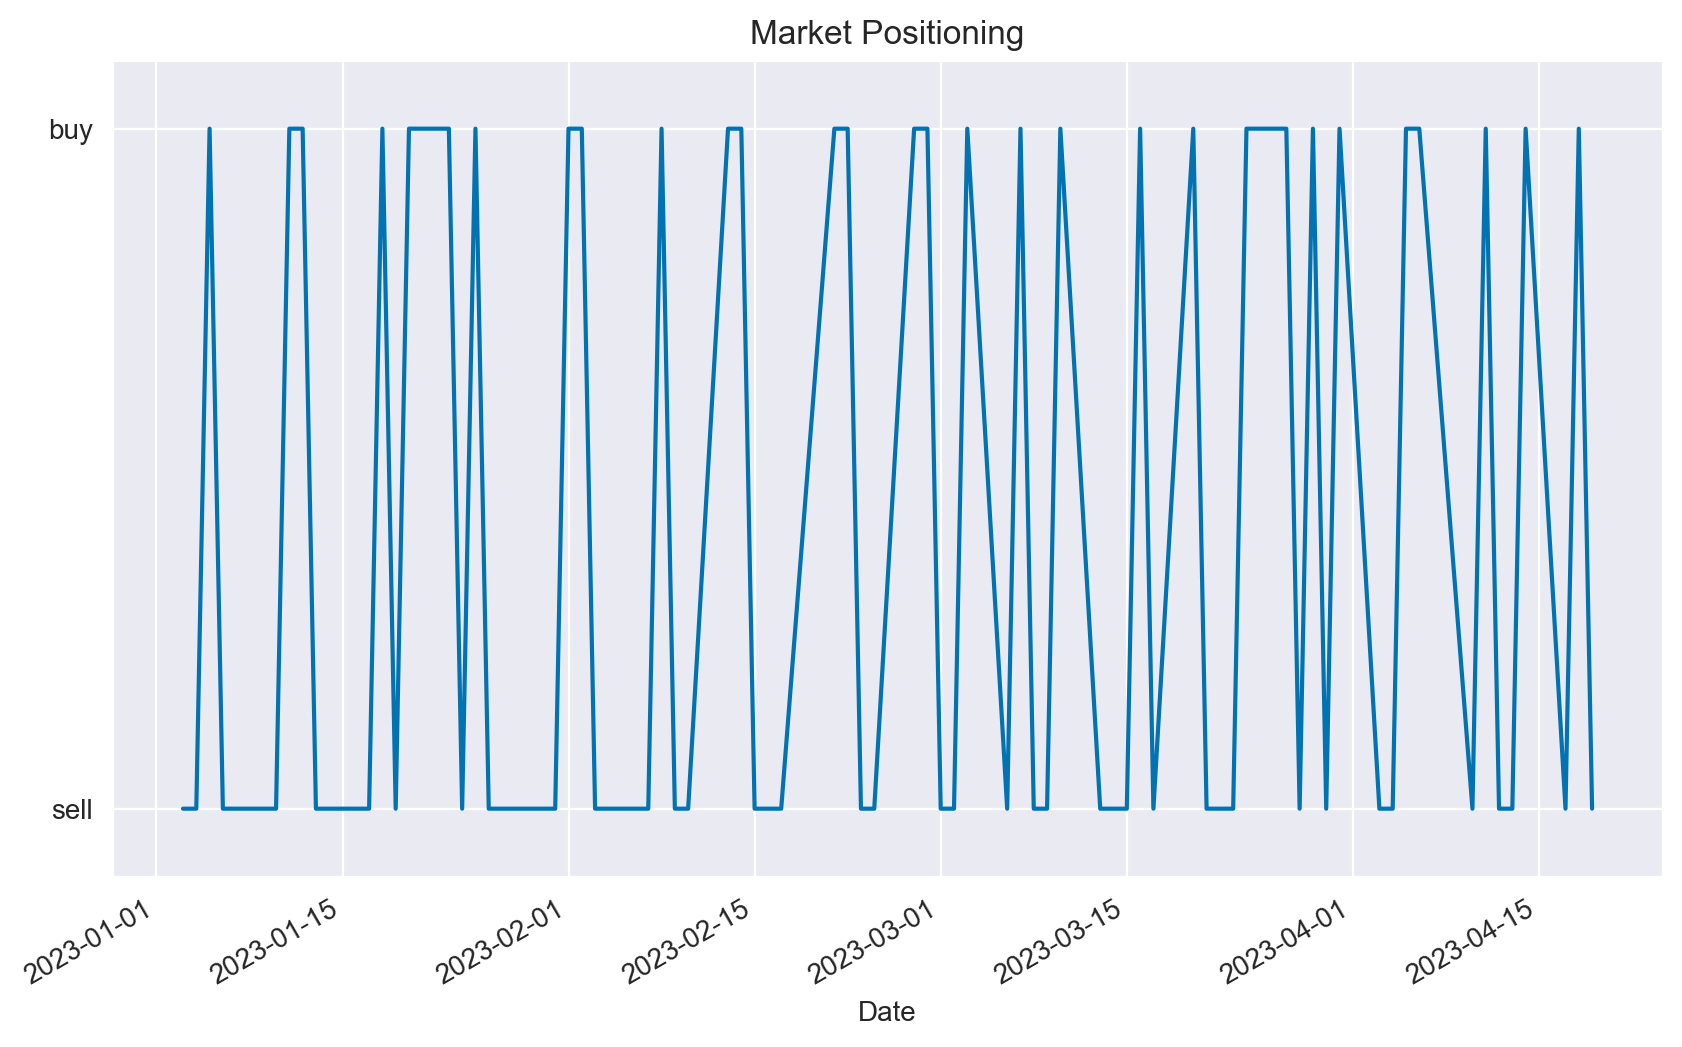

In [106]:
buy_sell_labels = {0.0: 'sell', 1.0: 'buy'}
ax = test['prediction'].plot(ylim=[-0.1, 1.1], title='Market Positioning', figsize=(10, 6))
_ = plt.yticks(list(buy_sell_labels.keys()), list(buy_sell_labels.values()))

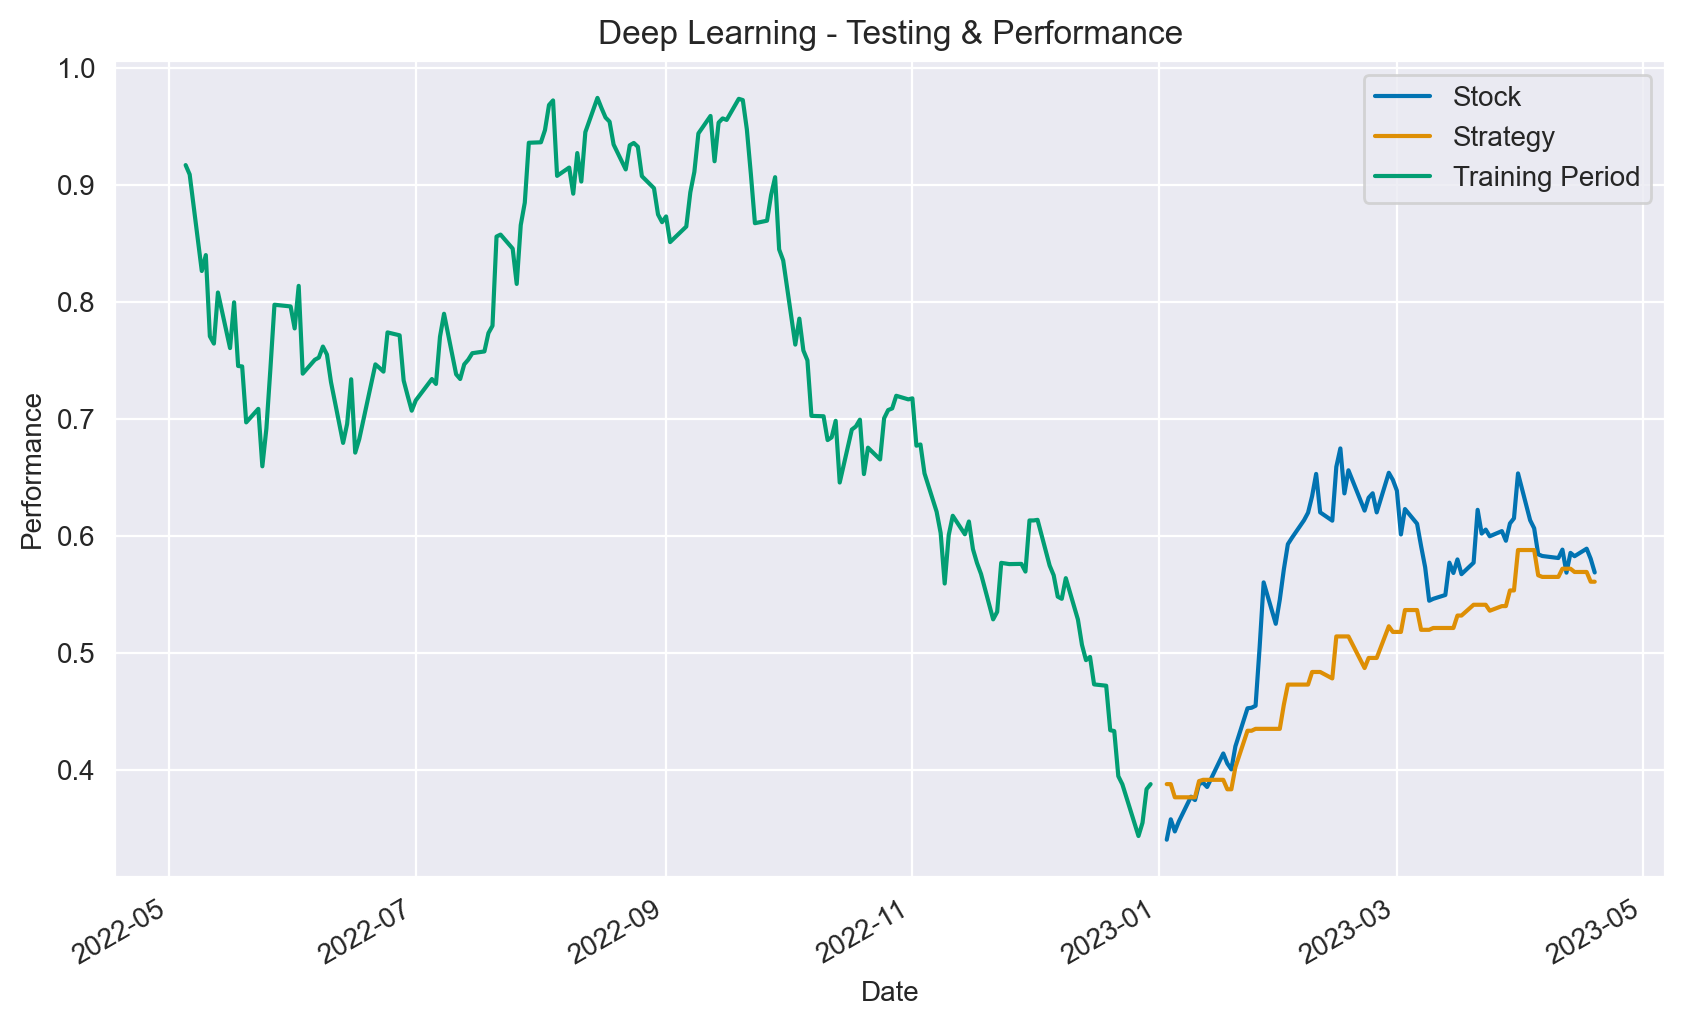

In [107]:
fig, ax = plt.subplots()

# performance plot
data = test[['return', 'strategy']].cumsum().apply(np.exp) 

# scale to match training data end point 
scaled_data = data * 0.38792

# plot scaled data
scaled_data.plot(ax=ax)

# training data plot
train[['return']].cumsum().apply(np.exp).plot(ax=ax, figsize=(10, 6))

ax.set_xlabel('Date')
ax.set_ylabel('Performance')
ax.set_title('Deep Learning - Testing & Performance')
ax.legend(['Stock', 'Strategy', 'Training Period'])

### Analysis
- Out of the indicator strategies, MACD performed better than momentum
- Among machine learning techniques, logistic regression outperformed linear regression, while the deep learning model was overfit
- In an attempt to follow the CRISP-DM process, at this point I will return to the data preparation stage, revise features & techniques, and evaluate the revised process 

## Revised Process
- New features including rolling averages of volume, daily low, and daily high to be added
- MACD indicator signal will be added as a feature
- Return to sklearn model with AdaBoost()

In [108]:
df = day_df[['Adj Close', 'Volume', 'return']].copy()
df.columns = ['price', 'vlm', 'return']
df.head()

price        vlm    return
Date                                       
2022-04-20  325.733337   70711200 -0.050825
2022-04-21  336.260010  105416400  0.031806
2022-04-22  335.016663   69696600 -0.003704
2022-04-25  332.673340   68341200 -0.007019
2022-04-26  292.140015  136133700 -0.129928

Adding new features:

In [109]:
window = 20

# volume
df['vlm'] = df['vlm'].rolling(window).mean()
# rolling min
df['min'] = df['price'].rolling(window).min()
# rolling max
df['max'] = df['price'].rolling(window).max()
# SMAs
df['sma1'] = df['price'].rolling(19).mean()
df['sma2'] = df['price'].rolling(21).mean()
# MACD signal 
df['sma_pos'] = np.where(df['sma1'] > df['sma2'], 1, -1)

In [110]:
df.dropna(inplace=True)
model_features = ['sma_pos', 'vlm', 'min', 'max', 'return']
lags=10

In [111]:
# create lag columns
cols = []
for f in model_features:
    for lag in range(1, lags + 1):
        col = f'{f}_lag_{lag}'
        df[col] = df[f].shift(lag)
        cols.append(col)

In [112]:
df.dropna(inplace=True)

- Revised model parameters

In [113]:
n_estimators=15
random_state=42
max_depth=1
min_samples_leaf=15
subsample=0.33

In [114]:
dtc = DecisionTreeClassifier(random_state=random_state, max_depth=max_depth, min_samples_leaf=min_samples_leaf)

In [115]:
model = AdaBoostClassifier(base_estimator=dtc, n_estimators=n_estimators, random_state=random_state)

- Split into train & test sets:

In [116]:
cutoff = '2023-01-01'

In [117]:
# applying normal distribution
train = df[df.index < cutoff].copy()
mu, std = train.mean(), train.std()
train_ = (train - mu) / std

In [118]:
train_['actual'] = np.where(train_['return'] > 0, 1, -1)
train['actual'] = np.where(train['return'] > 0, 1, -1)
train['actual'] = train['actual'] .astype('category')
train_['actual'] = train_['actual'] .astype('category')

In [119]:
# with normal distribution
train_.head()

price       vlm    return       min       max      sma1  \
Date                                                                     
2022-06-02  0.473728  0.608235  1.275939 -0.117444  0.617718  0.099187   
2022-06-03  0.000579  0.671940 -2.327164 -0.117444  0.555138  0.028502   
2022-06-06  0.075343  0.708166  0.522287 -0.117444  0.017008 -0.003012   
2022-06-07  0.087395  0.650464  0.183902 -0.117444  0.017008 -0.039371   
2022-06-08  0.146596  0.624208  0.433183 -0.117444 -0.188368 -0.043034   

                sma2   sma_pos  sma_pos_lag_1  sma_pos_lag_2  ...  \
Date                                                          ...   
2022-06-02  0.228919 -0.726386      -0.726386      -0.726386  ...   
2022-06-03  0.128525 -0.726386      -0.726386      -0.726386  ...   
2022-06-06  0.064662 -0.726386      -0.726386      -0.726386  ...   
2022-06-07  0.004607 -0.726386      -0.726386      -0.726386  ...   
2022-06-08 -0.020186 -0.726386      -0.726386      -0.726386  ...   

            return_lag_2  return_lag_3  return_lag_4  return_lag_5  \
Date                                                                 
2022-06-02      0.095038      1.933091      1.955925      1.315513   
2022-06-03     -0.471737      0.087505      1.933310      1.933632   
2022-06-06      1.315285     -0.473771      0.055112      1.911143   
2022-06-07     -2.342437      1.295913     -0.516083      0.043368   
2022-06-08      0.550208     -2.326321      1.284872     -0.524657   

            return_lag_6  return_lag_7  return_lag_8  return_lag_9  \
Date                                                                 
2022-06-02     -1.774531      0.509301     -1.647605      0.066210   
2022-06-03      1.321897     -1.776146      0.509173     -1.647910   
2022-06-06      1.944778      1.317531     -1.789743      0.508838   
2022-06-07      1.922115      1.939859      1.322167     -1.790045   
2022-06-08      0.039952      1.917217      1.948162      1.321820   

            return_lag_10  actual  
Date                               
2022-06-02      -1.741364       1  
2022-06-03       0.069726      -1  
2022-06-06      -1.634568       1  
2022-06-07       0.509818       1  
2022-06-08      -1.775890       1  

[5 rows x 59 columns]

- Fitting & evaluating revised model:

In [120]:
model.fit(train_[cols], train_['actual'])

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1,
                                                         min_samples_leaf=15,
                                                         random_state=42),
                   n_estimators=15, random_state=42)

In [121]:
accuracy_score(train_['actual'], model.predict(train_[cols]))

0.8435374149659864

In [122]:
train['prediction'] = model.predict(train_[cols])

In [123]:
train['prediction'][train['prediction'] < 0] = 0
train['strategy'] = (train['prediction'] * train['return']) 

In [124]:
# performance summary
pct = train[['return', 'strategy']].sum().apply(np.exp)
pct

print(f'Strategy outperformed stock by {(pct[1]-pct[0]).round(2)}')

Strategy outperformed stock by 2.5


Text(0.5, 1.0, 'Training Data')

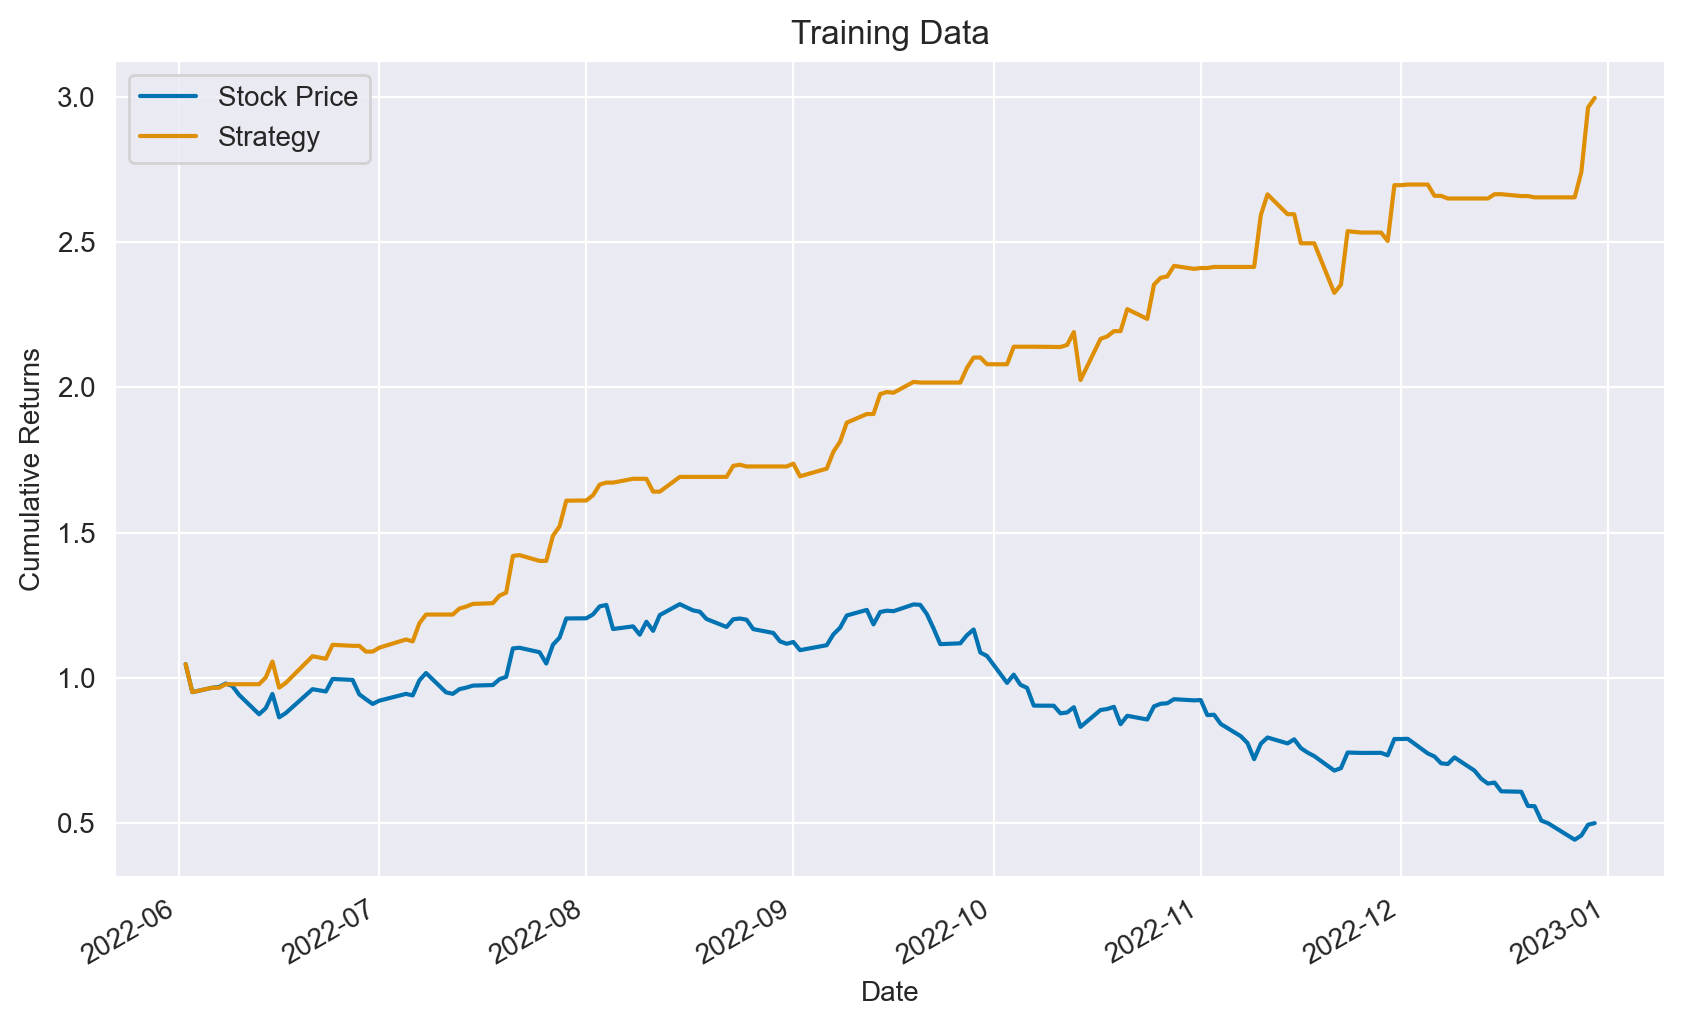

In [125]:
# Plot the data and set the legend label for 'return' to 'stock price'
ax = train[['return', 'strategy']].cumsum().apply(np.exp).plot(figsize=(10, 6))
ax.legend(['Stock Price', 'Strategy'])

# Set the axis labels and title
ax.set_xlabel('Date')
ax.set_ylabel('Cumulative Returns')
ax.set_title('Training Data')

- With a performance like this, I anticipate another overfit model

In [126]:
# normalizing test data
test = df[df.index >= cutoff].copy()
test_ = (test - mu) / std

In [127]:
test['prediction'] = model.predict(test_[cols])

In [128]:
test_['actual'] = np.where(test_['return'] > 0, 1, -1)
test['actual'] = np.where(test['return'] > 0, 1, -1)
test['actual'] = test['actual'] .astype('category')
test_['actual'] = test_['actual'] .astype('category')

In [129]:
accuracy_score(test['actual'], test['prediction'])

0.6351351351351351

In [130]:
test.prediction[test.prediction < 0] = 0
test['strategy'] = test['prediction'] * test['return']

Text(0.5, 1.0, 'Test Data')

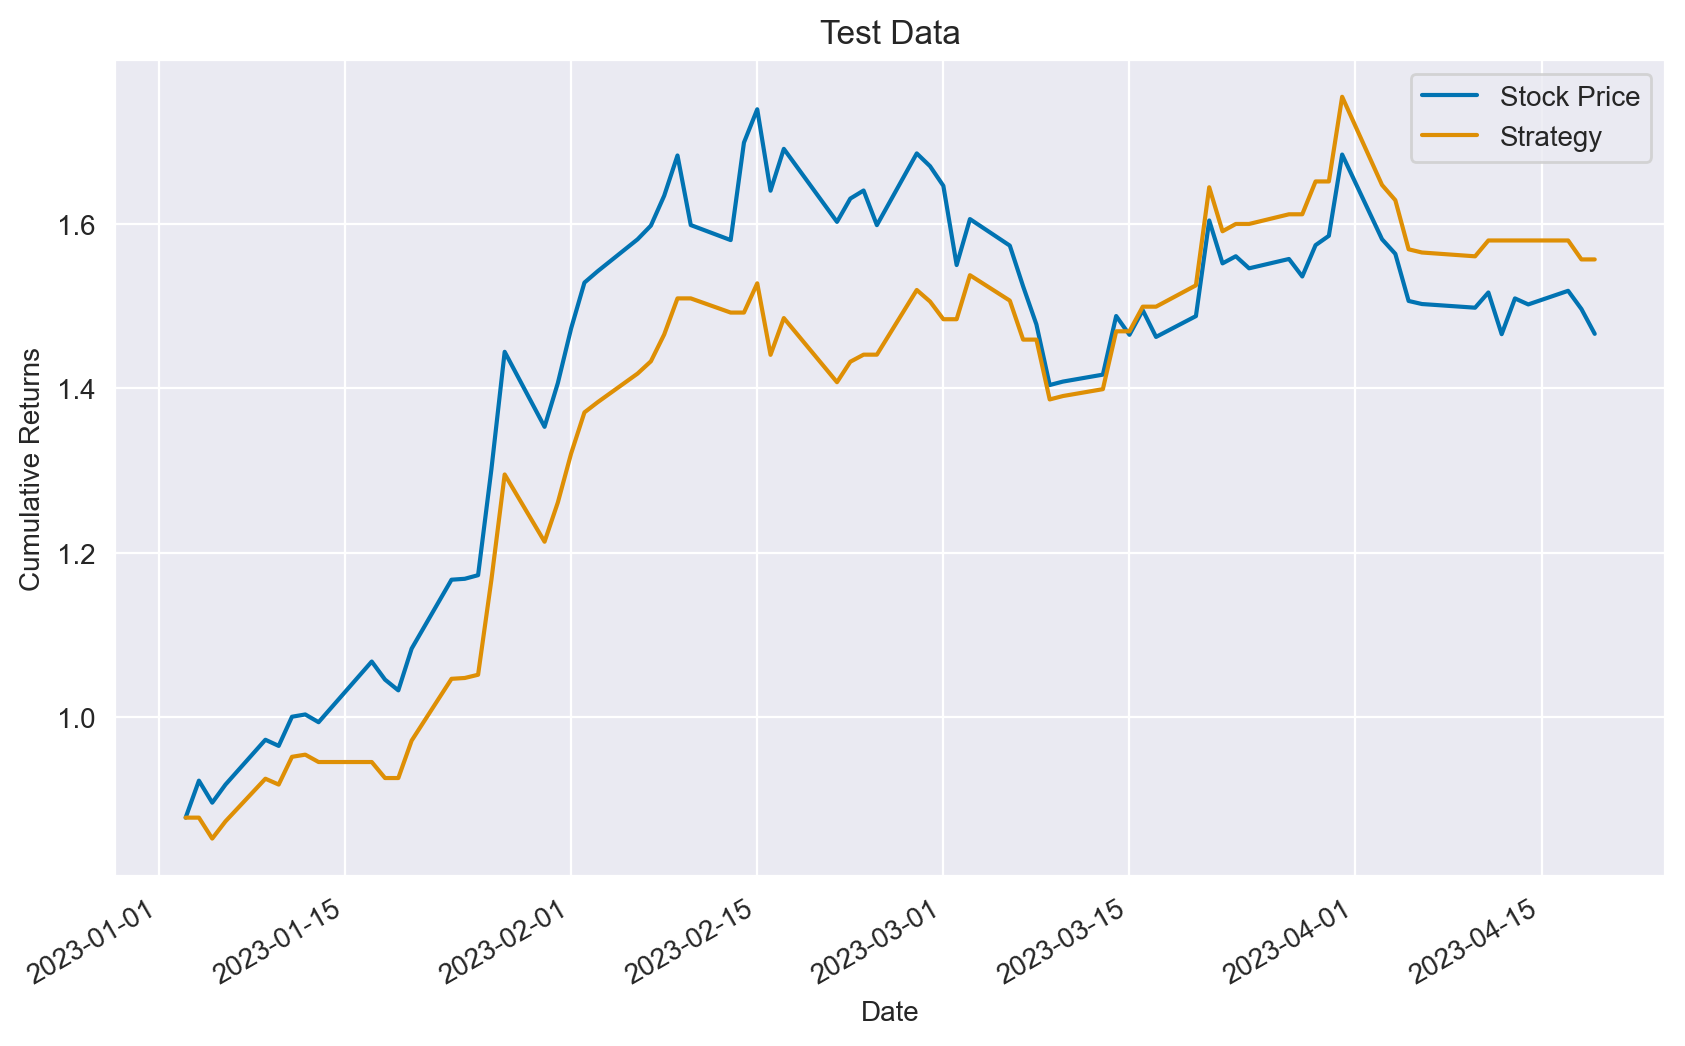

In [131]:
# Plot the data and set the legend label for 'return' to 'stock price'
ax = test[['return', 'strategy']].cumsum().apply(np.exp).plot(figsize=(10, 6))
ax.legend(['Stock Price', 'Strategy'])

# Set the axis labels and title
ax.set_xlabel('Date')
ax.set_ylabel('Cumulative Returns')
ax.set_title('Test Data')

- Although the model is overfit, the test accuracy isn't bad and the strategy did perform better than the stock

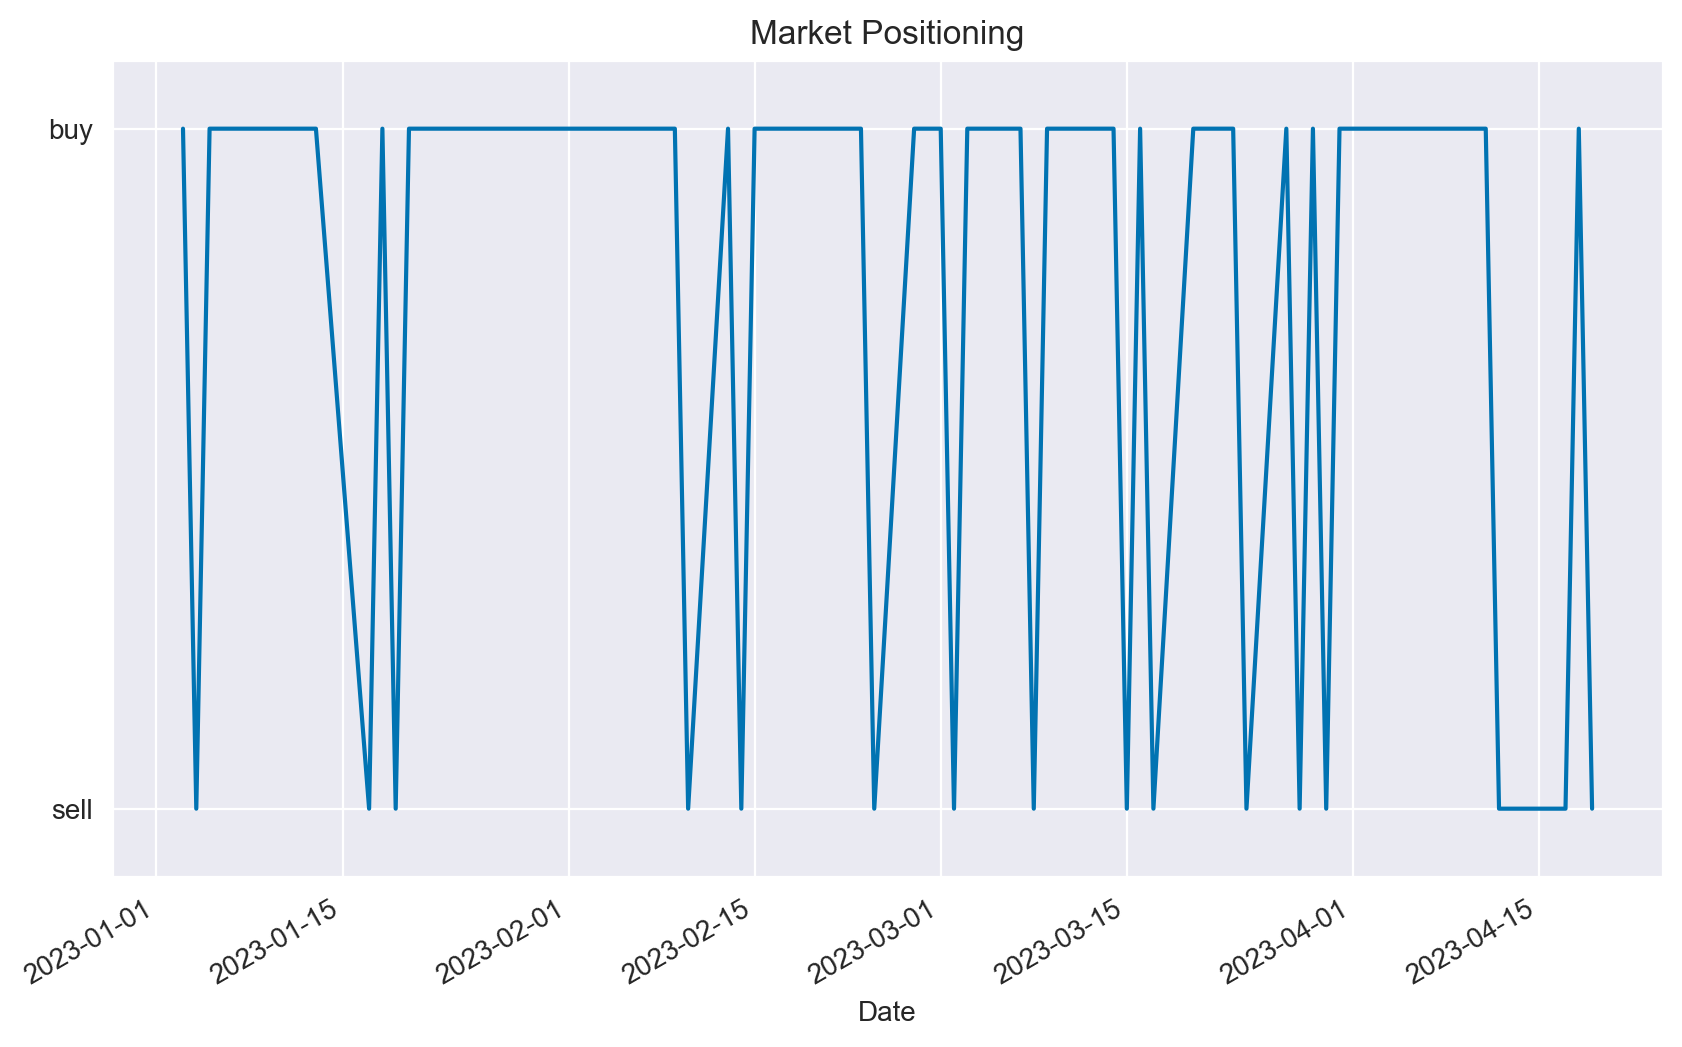

In [132]:
buy_sell_labels = {0.0: 'sell', 1.0: 'buy'}
ax = test['prediction'].plot(ylim=[-0.1, 1.1], title='Market Positioning', figsize=(10, 6))
_ = plt.yticks(list(buy_sell_labels.keys()), list(buy_sell_labels.values()))

In [133]:
# performance summary
pct = test[['return', 'strategy']].sum().apply(np.exp)
pct

return      1.466066
strategy    1.556609
dtype: float64

In [134]:
print(f'Strategy outperformed stock by {(pct[1]-pct[0]).round(2)}')

Strategy outperformed stock by 0.09


In [135]:
# scale test data to this point
train[['return']].loc[:'2022-12-30'].sum().apply(np.exp)

return    0.499129
dtype: float64

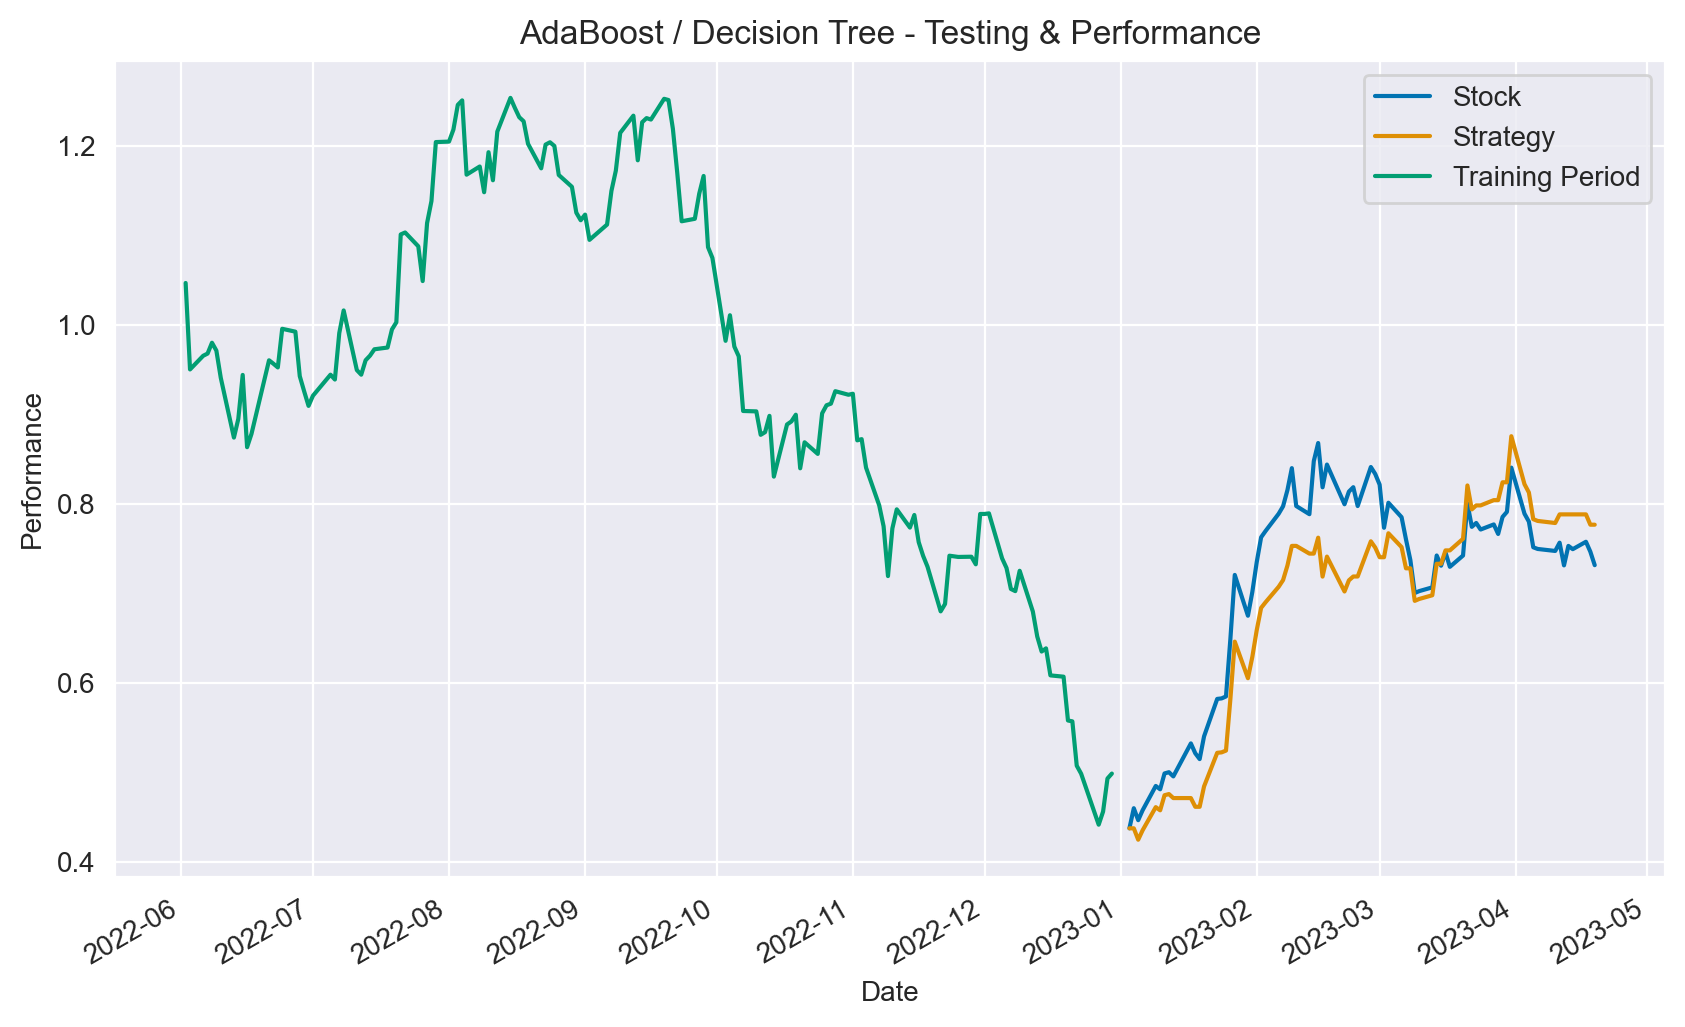

In [136]:
fig, ax = plt.subplots()

# performance plot
data = test[['return', 'strategy']].cumsum().apply(np.exp) 

# scale to match training data end point 
scaled_data = data * 0.499129

# plot scaled data
scaled_data.plot(ax=ax)

# training data plot
train[['return']].cumsum().apply(np.exp).plot(ax=ax, figsize=(10, 6))

ax.set_xlabel('Date')
ax.set_ylabel('Performance')
ax.set_title('AdaBoost / Decision Tree - Testing & Performance')
ax.legend(['Stock', 'Strategy', 'Training Period'])

## Final evaluation

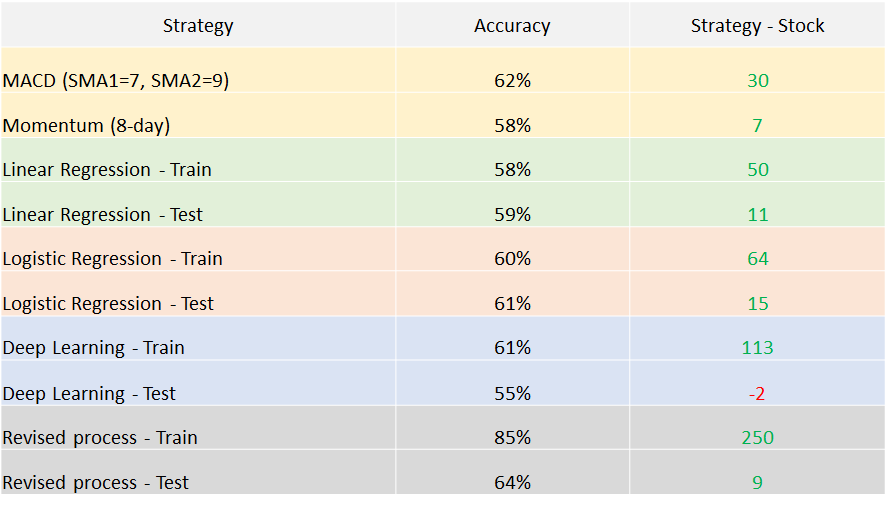

- The revised process with additional features that used AdaBoost had the highest accuracy among test data
- Logistic regression performed best financially among ML methods, but MACD performed best overall